In [1]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

tf.compat.v1.random.set_random_seed(42)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from math import floor

from utils import concordance_index_censored_scorer,concordance_index_ipcw_scorer,integrated_brier_scorer,cumulative_dynamic_auc_scorer
from utils import log_rank_test,log_rank_test_scorer
from utils import reduce_T_max,reduce_uncensored

from sklearn.model_selection import KFold

import json
import os

from sksurv.nonparametric import kaplan_meier_estimator

from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize,LogNorm
from matplotlib.cm import ScalarMappable

In [2]:
NAME = "metabric"
NAME_PLOT = "METABRIC"

plt.rcParams.update({'font.size': 20})

pd.set_option('display.max_columns', None)
df = pd.read_csv("Data/metabric.tsv",sep="\t",header=4).drop(["PATIENT_ID","VITAL_STATUS","RFS_MONTHS"],axis=1)

timeline_resolution = 200

T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]
from itertools import product
sensitivity_grid = np.array(list(product(T_maxs,red_rates))) # [:,0] -> T_maxs, [:,1] -> red_rates

# Preprocessing

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sksurv.column import encode_categorical

In [4]:
cell = []
for c in df.CELLULARITY:
    if c == "Low":
        cell.append(0.0)
    elif c == "Moderate":
        cell.append(0.5)
    elif c == "High":
        cell.append(1.0)
    else:
        cell.append(np.NaN)
df.CELLULARITY = cell

In [5]:
df_original = df.copy()

In [6]:
df = df.dropna()
df = encode_categorical(df)
#df = df.drop("HISTOLOGICAL_SUBTYPE=Metaplastic",axis=1)

S:\workspace\gerincmet\venv\lib\site-packages\sksurv\column.py:137: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  columns_to_encode = {nam for nam, s in table.iteritems() if _is_categorical_or_object(s)}
S:\workspace\gerincmet\venv\lib\site-packages\sksurv\column.py:142: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, series in table.iteritems():
dropped categorical variable 'SEX', because it has only 1 values


In [7]:
df.head()

LYMPH_NODES_EXAMINED_POSITIVE    NPI  CELLULARITY  CHEMOTHERAPY=YES  \
1                             0.0  4.020          1.0               0.0   
4                             8.0  6.080          1.0               1.0   
5                             0.0  4.062          0.5               0.0   
10                            1.0  5.032          0.5               0.0   
11                            0.0  3.056          1.0               0.0   

    COHORT  ER_IHC=Positve  HER2_SNP6=LOSS  HER2_SNP6=NEUTRAL  \
1      1.0             1.0             0.0                1.0   
4      1.0             1.0             0.0                1.0   
5      1.0             1.0             0.0                1.0   
10     1.0             1.0             0.0                0.0   
11     1.0             0.0             1.0                0.0   

    HER2_SNP6=UNDEF  HORMONE_THERAPY=YES  INFERRED_MENOPAUSAL_STATE=Pre  \
1               0.0                  1.0                            1.0   
4               0.0                  1.0                            0.0   
5               0.0                  1.0                            0.0   
10              0.0                  1.0                            0.0   
11              0.0                  0.0                            0.0   

    INTCLUST=10  INTCLUST=2  INTCLUST=3  INTCLUST=4ER+  INTCLUST=4ER-  \
1           0.0         0.0         0.0            1.0            0.0   
4           0.0         0.0         0.0            0.0            0.0   
5           0.0         0.0         0.0            0.0            0.0   
10          0.0         0.0         0.0            0.0            0.0   
11          0.0         0.0         1.0            0.0            0.0   

    INTCLUST=5  INTCLUST=6  INTCLUST=7  INTCLUST=8  INTCLUST=9  \
1          0.0         0.0         0.0         0.0         0.0   
4          0.0         0.0         0.0         0.0         1.0   
5          0.0         0.0         1.0         0.0         0.0   
10         0.0         0.0         0.0         0.0         1.0   
11         0.0         0.0         0.0         0.0         0.0   

    AGE_AT_DIAGNOSIS  OS_MONTHS  OS_STATUS=1:DECEASED  CLAUDIN_SUBTYPE=Her2  \
1              43.19  84.633333                   0.0                   0.0   
4              76.97  41.366667                   1.0                   0.0   
5              78.77   7.800000                   1.0                   0.0   
10             86.41  36.566667                   1.0                   0.0   
11             84.22  36.266667                   1.0                   1.0   

    CLAUDIN_SUBTYPE=LumA  CLAUDIN_SUBTYPE=LumB  CLAUDIN_SUBTYPE=NC  \
1                    1.0                   0.0                 0.0   
4                    0.0                   1.0                 0.0   
5                    0.0                   1.0                 0.0   
10                   0.0                   1.0                 0.0   
11                   0.0                   0.0                 0.0   

    CLAUDIN_SUBTYPE=Normal  CLAUDIN_SUBTYPE=claudin-low  \
1                      0.0                          0.0   
4                      0.0                          0.0   
5                      0.0                          0.0   
10                     0.0                          0.0   
11                     0.0                          0.0   

    THREEGENE=ER+/HER2- Low Prolif  THREEGENE=ER-/HER2-  THREEGENE=HER2+  \
1                              0.0                  0.0              0.0   
4                              0.0                  0.0              0.0   
5                              0.0                  0.0              0.0   
10                             0.0                  0.0              0.0   
11                             0.0                  0.0              0.0   

    LATERALITY=Right  RADIO_THERAPY=YES  HISTOLOGICAL_SUBTYPE=Lobular  \
1                1.0                1.0                           0.0   
4                1.0 

In [8]:
cont_features = ["LYMPH_NODES_EXAMINED_POSITIVE","NPI","CELLULARITY","AGE_AT_DIAGNOSIS"]

In [9]:
scaler = MinMaxScaler()
df[cont_features] = scaler.fit_transform(df[cont_features])

In [10]:
time_scaler = MinMaxScaler()
df.OS_MONTHS = time_scaler.fit_transform(df.OS_MONTHS.to_numpy().reshape(-1, 1))

In [11]:
df.head()

LYMPH_NODES_EXAMINED_POSITIVE       NPI  CELLULARITY  CHEMOTHERAPY=YES  \
1                        0.000000  0.561798          1.0               0.0   
4                        0.195122  0.947566          1.0               1.0   
5                        0.000000  0.569663          0.5               0.0   
10                       0.024390  0.751311          0.5               0.0   
11                       0.000000  0.381273          1.0               0.0   

    COHORT  ER_IHC=Positve  HER2_SNP6=LOSS  HER2_SNP6=NEUTRAL  \
1      1.0             1.0             0.0                1.0   
4      1.0             1.0             0.0                1.0   
5      1.0             1.0             0.0                1.0   
10     1.0             1.0             0.0                0.0   
11     1.0             0.0             1.0                0.0   

    HER2_SNP6=UNDEF  HORMONE_THERAPY=YES  INFERRED_MENOPAUSAL_STATE=Pre  \
1               0.0                  1.0                            1.0   
4               0.0                  1.0                            0.0   
5               0.0                  1.0                            0.0   
10              0.0                  1.0                            0.0   
11              0.0                  0.0                            0.0   

    INTCLUST=10  INTCLUST=2  INTCLUST=3  INTCLUST=4ER+  INTCLUST=4ER-  \
1           0.0         0.0         0.0            1.0            0.0   
4           0.0         0.0         0.0            0.0            0.0   
5           0.0         0.0         0.0            0.0            0.0   
10          0.0         0.0         0.0            0.0            0.0   
11          0.0         0.0         1.0            0.0            0.0   

    INTCLUST=5  INTCLUST=6  INTCLUST=7  INTCLUST=8  INTCLUST=9  \
1          0.0         0.0         0.0         0.0         0.0   
4          0.0         0.0         0.0         0.0         1.0   
5          0.0         0.0         1.0         0.0         0.0   
10         0.0         0.0         0.0         0.0         1.0   
11         0.0         0.0         0.0         0.0         0.0   

    AGE_AT_DIAGNOSIS  OS_MONTHS  OS_STATUS=1:DECEASED  CLAUDIN_SUBTYPE=Her2  \
1           0.285906   0.250890                   0.0                   0.0   
4           0.740183   0.122477                   1.0                   0.0   
5           0.764389   0.022853                   1.0                   0.0   
10          0.867133   0.108231                   1.0                   0.0   
11          0.837682   0.107341                   1.0                   1.0   

    CLAUDIN_SUBTYPE=LumA  CLAUDIN_SUBTYPE=LumB  CLAUDIN_SUBTYPE=NC  \
1                    1.0                   0.0                 0.0   
4                    0.0                   1.0                 0.0   
5                    0.0                   1.0                 0.0   
10                   0.0                   1.0                 0.0   
11                   0.0                   0.0                 0.0   

    CLAUDIN_SUBTYPE=Normal  CLAUDIN_SUBTYPE=claudin-low  \
1                      0.0                          0.0   
4                      0.0                          0.0   
5                      0.0                          0.0   
10                     0.0                          0.0   
11                     0.0                          0.0   

    THREEGENE=ER+/HER2- Low Prolif  THREEGENE=ER-/HER2-  THREEGENE=HER2+  \
1                              0.0                  0.0              0.0   
4                              0.0                  0.0              0.0   
5                              0.0                  0.0              0.0   
10                             0.0                  0.0              0.0   
11                             0.0                  0.0              0.0   

    LATERALITY=Right  RADIO_THERAPY=YES  HISTOLOGICAL_SUBTYPE=Lobular  \
1                1.0                1.0                           0.0   
4  

In [12]:
# Divede the data
X = df.drop(["OS_MONTHS","OS_STATUS=1:DECEASED"],axis = 1)
x_size = len(X.columns)
X = np.float32(X.to_numpy())
t = np.float32(df.OS_MONTHS.to_numpy())
delta = df["OS_STATUS=1:DECEASED"].to_numpy().astype(np.float32)
y = np.stack([t,delta],axis = 1)

In [13]:
# Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]

# Create a timeline for evaluation
t_max = min([t_max,max(y_test[:,0])])
t_min = max([t_min,min(y_test[:,0])])
timeline = np.linspace(t_min,t_max,timeline_resolution,endpoint=False).astype(np.float32)

# Exploration

In [72]:
# Dataset statistics

properties = {"Dataset": NAME_PLOT,
              "Num. of Patients": len(df_original),
              "Num. of Features": len(df_original.columns),
              "Num. of Numeric Features": len(cont_features),
              "Num. of Categorical Features": len(df_original.columns)-len(cont_features),
              "Mean Survival": round(np.mean(df_original.OS_MONTHS),2),
              "Min. Survival": round(min(df_original.OS_MONTHS),2),
              "Max. Survival": round(max(df_original.OS_MONTHS),2),
              "Num. of Censored": len(df_original[df_original["OS_STATUS"] == "0:LIVING"]),
              "Censored %": round(len(df_original[df_original["OS_STATUS"] == "0:LIVING"])/len(df_original)*100,2),
              "Censored Mean Survival": round(np.mean(df_original.OS_MONTHS[df_original["OS_STATUS"] == "0:LIVING"]),2),
              "Censored Min. Survival": round(min(df_original.OS_MONTHS[df_original["OS_STATUS"] == "0:LIVING"]),2),
              "Censored Max. Survival": round(max(df_original.OS_MONTHS[df_original["OS_STATUS"] == "0:LIVING"]),2),
              "Num. of Uncensored": len(df_original[df_original["OS_STATUS"] == "1:DECEASED"]),
              "Uncensored %": round(len(df_original[df_original["OS_STATUS"] == "1:DECEASED"])/len(df_original)*100,2),
              "Uncensored Mean Survival": round(np.mean(df_original.OS_MONTHS[df_original["OS_STATUS"] == "1:DECEASED"]),2),
              "Uncensored Min. Survival": round(min(df_original.OS_MONTHS[df_original["OS_STATUS"] == "1:DECEASED"]),2),
              "Uncensored Max. Survival": round(max(df_original.OS_MONTHS[df_original["OS_STATUS"] == "1:DECEASED"]),2)}

_ = [print(key,':',value) for key, value in properties.items()]

Dataset : METABRIC
Num. of Patients : 2509
Num. of Features : 21
Num. of Numeric Features : 4
Num. of Categorical Features : 17
Mean Survival : 125.24
Min. Survival : 0.0
Max. Survival : 355.2
Num. of Censored : 837
Censored % : 33.36
Censored Mean Survival : 159.14
Censored Min. Survival : 0.0
Censored Max. Survival : 337.03
Num. of Uncensored : 1144
Uncensored % : 45.6
Uncensored Mean Survival : 100.44
Uncensored Min. Survival : 0.1
Uncensored Max. Survival : 355.2


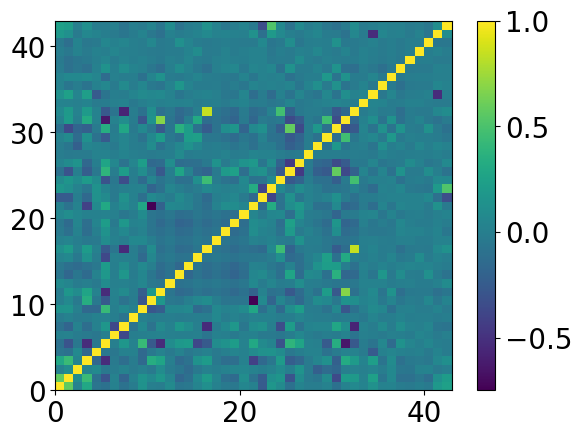

In [73]:
plt.pcolor(df.corr())
plt.colorbar()

In [74]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
cox_test_df = pd.DataFrame(np.append(np.vstack([y_train,y_test]),np.hstack([np.zeros(len(y_train)).T,np.ones(len(y_test))]).reshape(-1,1),axis=1))

cph = CoxPHFitter()
cph.fit(df = cox_test_df,
        duration_col = 0,
        event_col = 1)

print(cph.summary)

#cph.check_assumptions(cox_test_df,
#                      show_plots=True,
#                      p_value_threshold=0.7)

print(cph.log_likelihood_ratio_test())

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.042597   1.043517  0.074027       -0.102494        0.187688   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.902584             1.206457     0.0  0.575424   

                  p  -log2(p)  
covariate                      
2          0.565005  0.823665  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.33 0.57      0.82


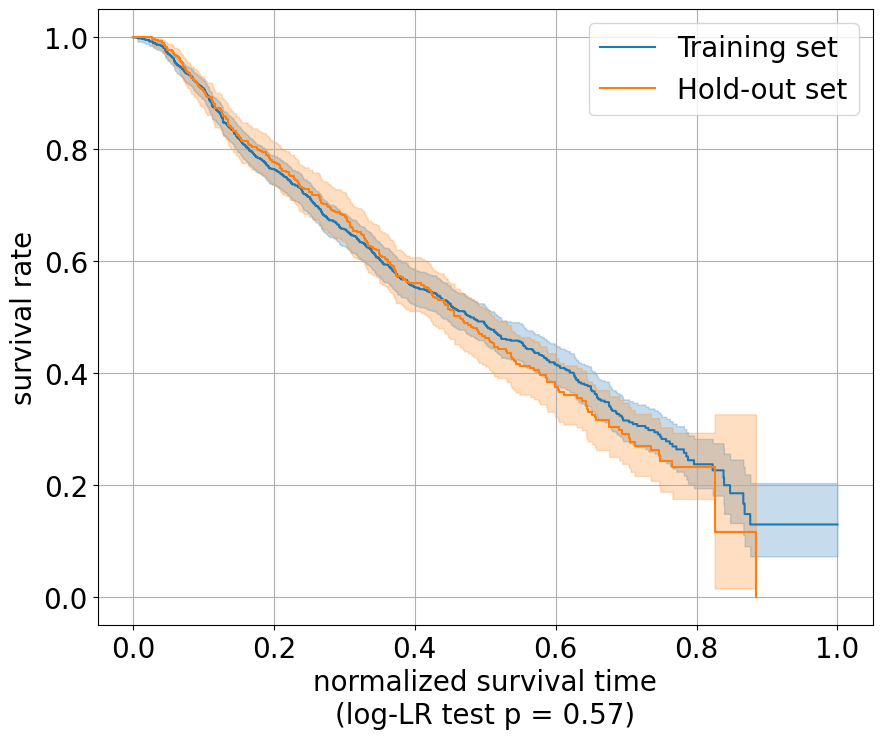

In [75]:
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter

plt.figure(figsize=(10,8))

kmf1 = KaplanMeierFitter(label="Training set")
kmf1.fit(y_train[:,0], y_train[:,1])
kmf1.plot()

kmf2 = KaplanMeierFitter(label="Hold-out set")
kmf2.fit(y_test[:,0], y_test[:,1])
kmf2.plot()

#plt.title("KM estimator of the training and hold-out sets")
plt.xlabel(f"normalized survival time\n(log-LR test p = {round(cph.log_likelihood_ratio_test().p_value,2)})")
plt.ylabel("survival rate")
plt.grid()
plt.show()

## Testing the 5Fold Cross Validation Data

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2         -0.238781   0.787587  0.107747       -0.449962         -0.0276   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.637652             0.972777     0.0 -2.216123   

                  p  -log2(p)  
covariate                      
2          0.026683  5.227931  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           5.17 0.02      5.44


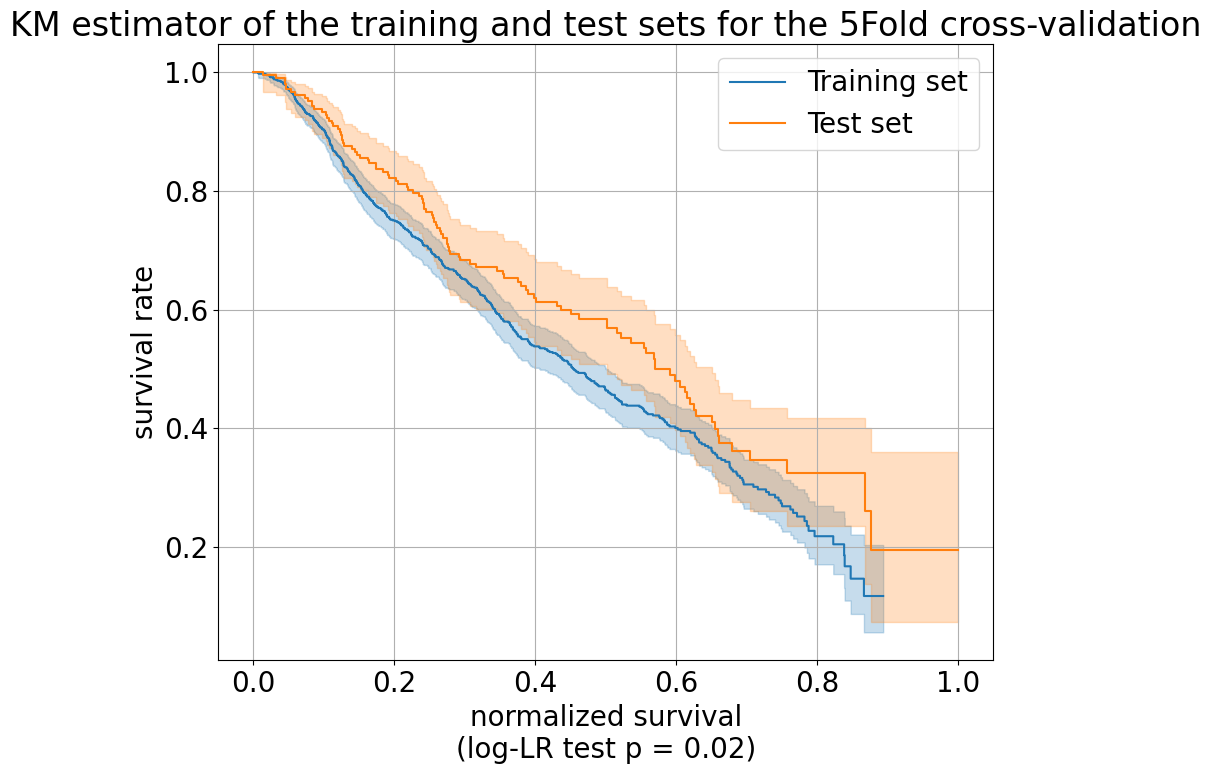

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.041591   1.042468  0.100958       -0.156284        0.239465   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.855316             1.270569     0.0  0.411958   

                 p  -log2(p)  
covariate                     
2          0.68037  0.555608  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.17 0.68      0.55


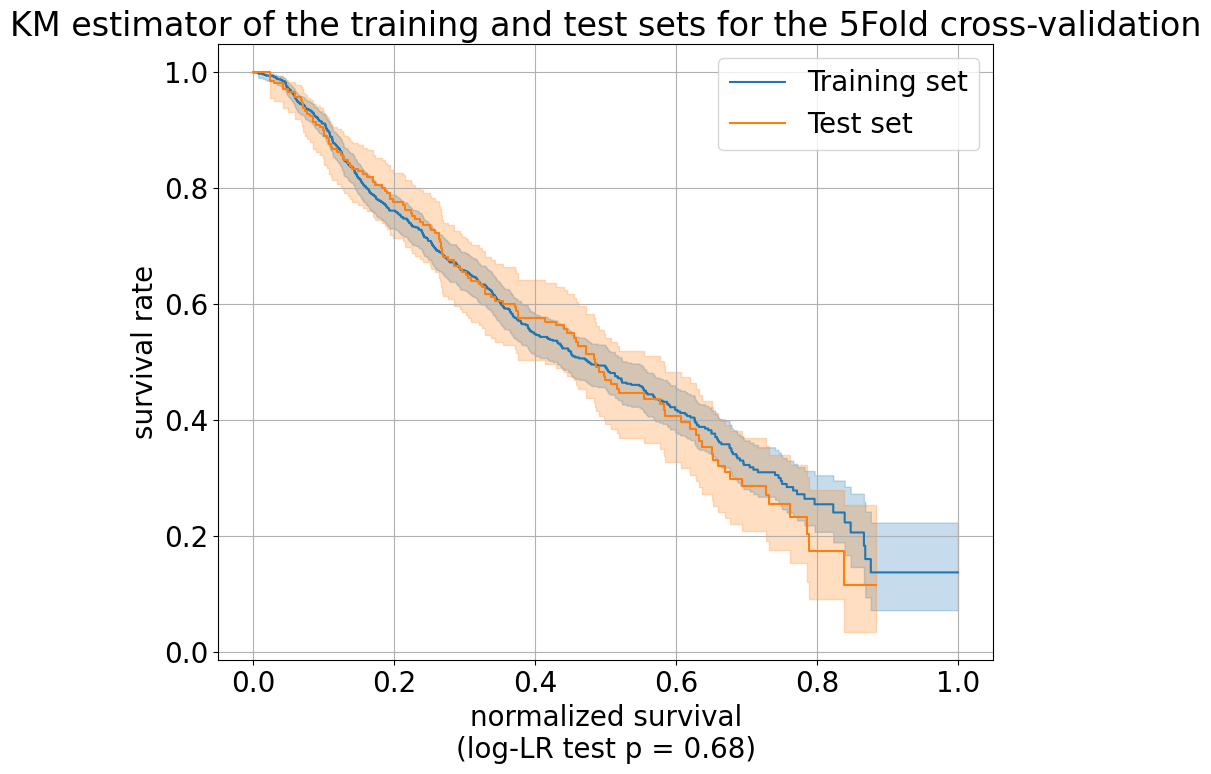

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.075256    1.07816  0.100105       -0.120947        0.271458   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.886081             1.311876     0.0  0.751765   

                  p  -log2(p)  
covariate                      
2          0.452192  1.144992  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.56 0.46      1.13


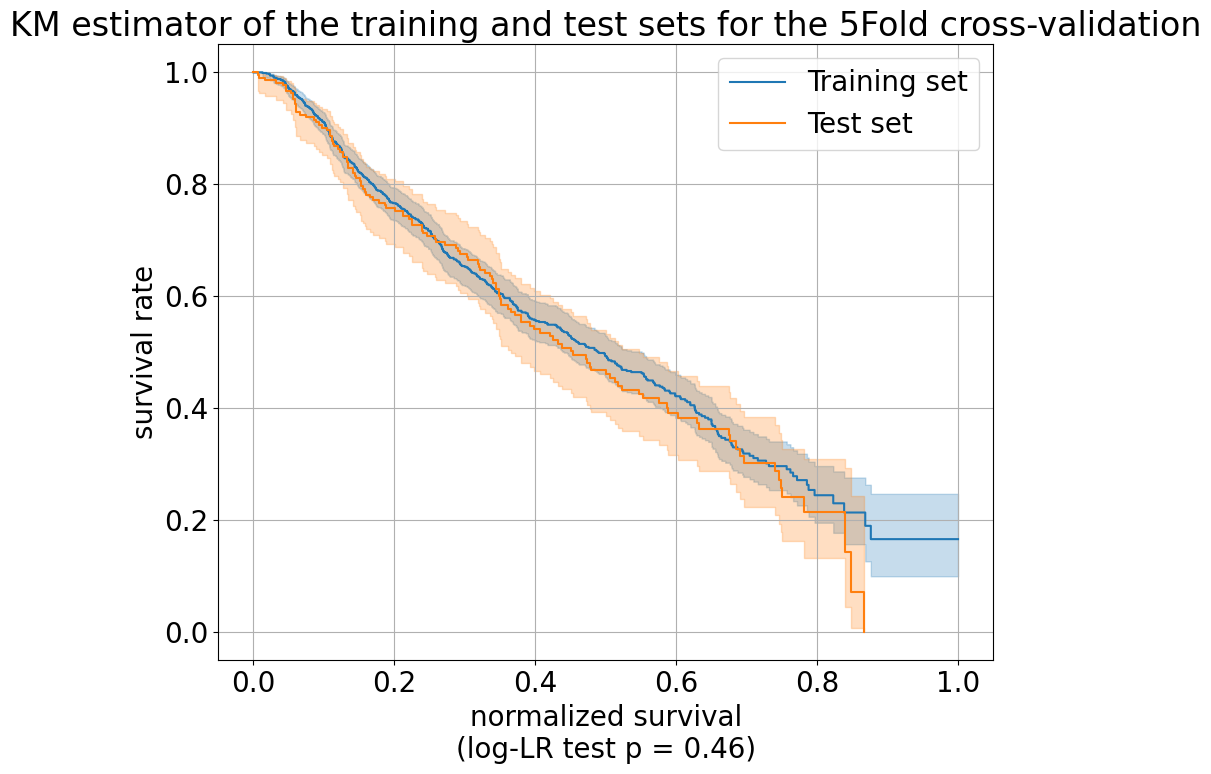

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
2          0.112035   1.118552  0.101904       -0.087693        0.311762   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.916042              1.36583     0.0  1.099416   

                  p  -log2(p)  
covariate                      
2          0.271587  1.880515  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.18 0.28      1.85


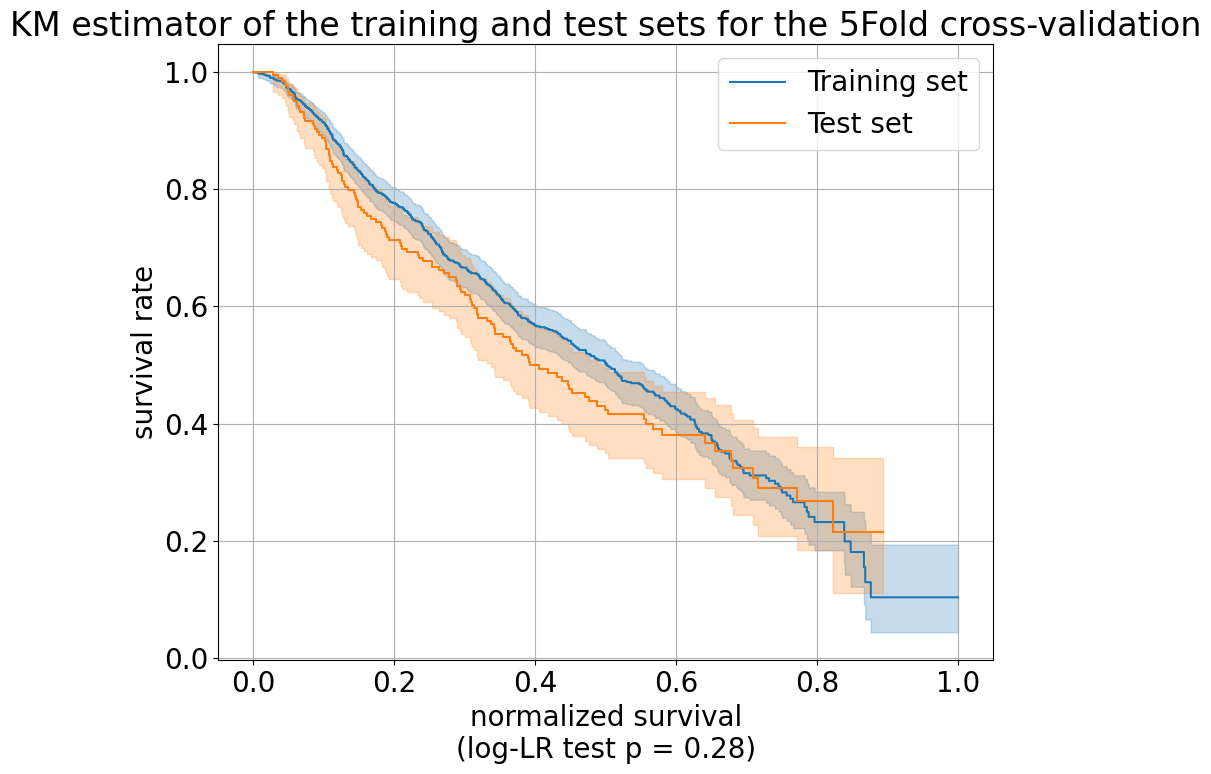

              coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                 
2          0.00376   1.003767  0.102598       -0.197329        0.204849   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
2                     0.820921              1.22734     0.0  0.036649   

                  p  -log2(p)  
covariate                      
2          0.970765  0.042807  
<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           0.00 0.97      0.04


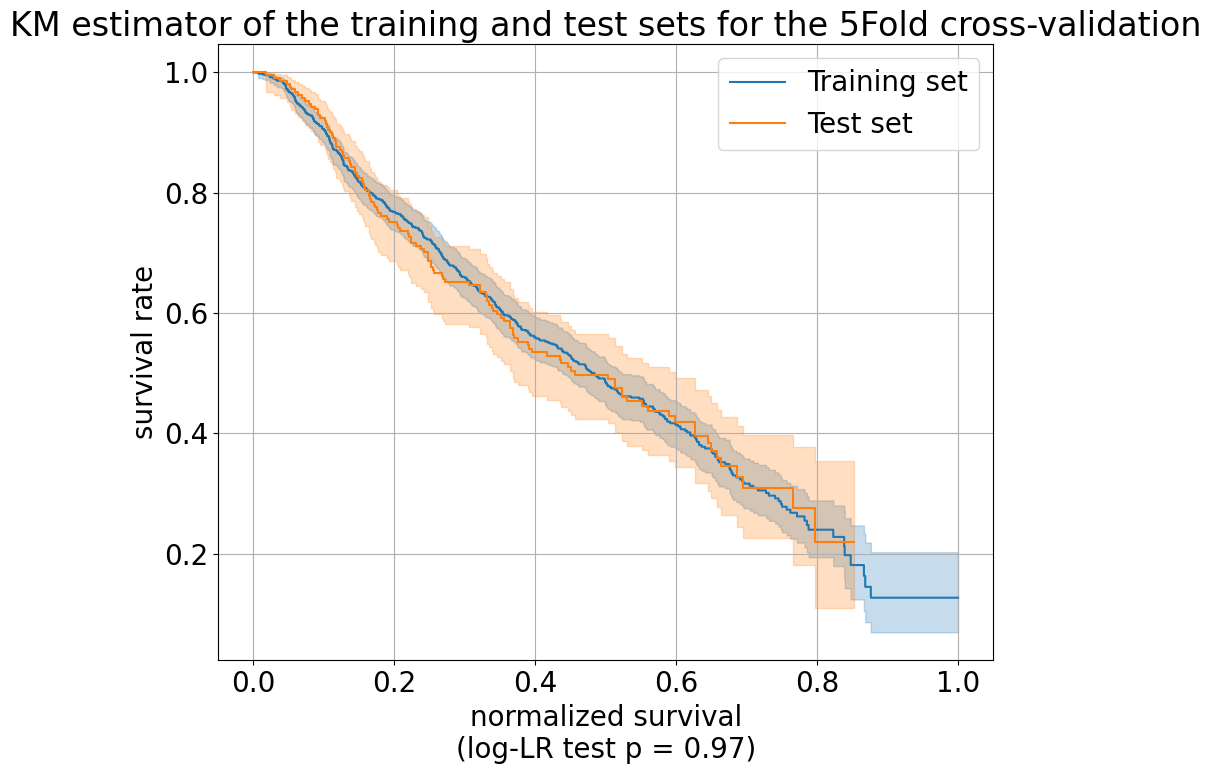

In [76]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)
for train_index, test_index in kf.split(y_train):
    y_train_train, y_train_test = y_train[train_index], y_train[test_index]
    
    #COX analysis
    
    cox_test_df = pd.DataFrame(np.append(np.vstack([y_train_train,y_train_test]),np.hstack([np.zeros(len(y_train_train)).T,np.ones(len(y_train_test))]).reshape(-1,1),axis=1))

    cph = CoxPHFitter()
    cph.fit(df = cox_test_df,
            duration_col = 0,
            event_col = 1)

    print(cph.summary)

    #cph.check_assumptions(cox_test_df,show_plots=True,p_value_threshold=0.7)
    #plt.show()

    print(cph.log_likelihood_ratio_test())
    p_val = round(cph.log_likelihood_ratio_test().p_value,2)
    
    # KM Plot
    plt.figure(figsize=(10,8))
    kmf1 = KaplanMeierFitter(label="Training set")
    kmf1.fit(y_train_train[:,0], y_train_train[:,1])
    kmf1.plot()
    kmf2 = KaplanMeierFitter(label="Test set")
    kmf2.fit(y_train_test[:,0], y_train_test[:,1])
    kmf2.plot()
    plt.title("KM estimator of the training and test sets for the 5Fold cross-validation")
    plt.xlabel(f"normalized survival\n(log-LR test p = {p_val})")
    plt.ylabel("survival rate")
    plt.grid()
    plt.show()

# Censoring Sensitivity Analysis

In [19]:
# Dictionary where all the results can be saved
results_table = {"Model":[],
                 "Optimized_LogRank":[],
                 "T_max":[],
                 "Uncensored_Reduction":[],
                 "5Fold":{"HarrelC":{"mean":[],
                                     "std":[]},
                          "UnoC":{"mean":[],
                                  "std":[]},
                          "iBrier":{"mean":[],
                                    "std":[]},
                          "AUROC":{"mean":[],
                                   "std":[]},
                          "LogRank":{"mean":[],
                                     "std":[]}},
                 "Hold-out":{"HarrelC":[],
                             "UnoC":[],
                             "iBrier":[],
                             "AUROC":[],
                             "LogRank":[]},
                 "Timeline":[],
                 "Overall_Survival_Function":[]}

with open(f"Logs/{NAME}_results.json", "w") as write_file:
        json.dump(results_table, write_file)

## MDN Model

### Shared Parameters

In [20]:
from model import MDN
from utils import NLLLoss, CensoredNLLLoss, AlternativeNLLLoss
from csa import MDNCensoringSensitivityAnalysis

# Fixed
num_epochs = 200
batch_size = 128
input_shape = x_size
learning_rate = 1e-3

<frozen importlib._bootstrap>:228: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


### Use LogRank in Optimizer

In [ ]:
# Hyperparameters [Optimized]
n_hidden = 1024
mixture_components = 8
use_sparse_layer = False
use_sparse_loss = False #Default
lmbd = 1e-4 #Default
use_batchnorm = False
use_dropout = True
dropout = 0.6197630727681631
mlp_size_1 = 2
mlp_size_2 = 4
mlp_size_3 = 1
kernel = "Gamma"
loss_name = AlternativeNLLLoss

# Properties
Model = MDN
model_name = "MDN"
Optimized_LogRank = True

MDNCSA = MDNCensoringSensitivityAnalysis(Model = Model,
                                         model_name = model_name,
                                         dataset_name = NAME,
                                         X = X,
                                         y = y,
                                         Optimized_LogRank = Optimized_LogRank)

MDNCSA.analyze(n_hidden = n_hidden,
               mixture_components = mixture_components,
               use_sparse_layer = use_sparse_layer,
               use_sparse_loss = use_sparse_loss,
               lmbd = lmbd,
               use_batchnorm = use_batchnorm,
               use_dropout = use_dropout,
               dropout = dropout,
               mlp_size_1 = mlp_size_1,
               mlp_size_2 = mlp_size_2,
               mlp_size_3 = mlp_size_3,
               kernel = kernel,
               loss_name = loss_name,
               num_epochs = num_epochs,
               batch_size = batch_size,
               input_shape = input_shape,
               learning_rate = learning_rate,
               timeline_resolution = timeline_resolution,
               sensitivity_grid = sensitivity_grid)

### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparameters [Optimized]
n_hidden = 256
mixture_components = 10
use_sparse_layer = True
use_sparse_loss = True
lmbd = 0.000014963805463910381
use_batchnorm = True
use_dropout = True
dropout = 0.7734249900448279
mlp_size_1 = 1
mlp_size_2 = 4
mlp_size_3 = 0
kernel = "Exponential"
loss_name = AlternativeNLLLoss

# Properties
Model = MDN
model_name = "MDN"
Optimized_LogRank = False

MDNCSA = MDNCensoringSensitivityAnalysis(Model = Model,
                                         model_name = model_name,
                                         dataset_name = NAME,
                                         X = X,
                                         y = y,
                                         Optimized_LogRank = Optimized_LogRank)

MDNCSA.analyze(n_hidden = n_hidden,
               mixture_components = mixture_components,
               use_sparse_layer = use_sparse_layer,
               use_sparse_loss = use_sparse_loss,
               lmbd = lmbd,
               use_batchnorm = use_batchnorm,
               use_dropout = use_dropout,
               dropout = dropout,
               mlp_size_1 = mlp_size_1,
               mlp_size_2 = mlp_size_2,
               mlp_size_3 = mlp_size_3,
               kernel = kernel,
               loss_name = loss_name,
               num_epochs = num_epochs,
               batch_size = batch_size,
               input_shape = input_shape,
               learning_rate = learning_rate,
               timeline_resolution = timeline_resolution,
               sensitivity_grid = sensitivity_grid)

### Compare LogRank vs. No LogRank

In [23]:
with open(f"Logs/{NAME}_results.json", "r") as read_file:
    results_table = json.load(read_file)

In [24]:
for i in range(len(results_table["Model"])):
    if (results_table["Model"][i] == "MDN") & (results_table["Optimized_LogRank"][i] == True) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
        tl_lr = np.array(results_table["Timeline"][i])
        osf_lr = np.array(results_table["Overall_Survival_Function"][i])

for i in range(len(results_table["Model"])):
    if (results_table["Model"][i] == "MDN") & (results_table["Optimized_LogRank"][i] == False) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
        tl_nlr = np.array(results_table["Timeline"][i])
        osf_nlr = np.array(results_table["Overall_Survival_Function"][i])

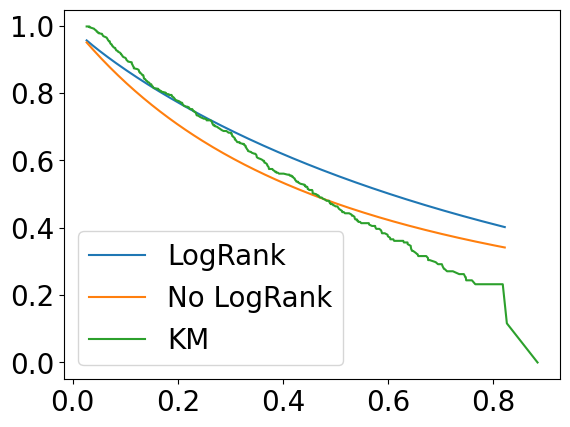

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]

km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(tl_lr, osf_lr, label = "LogRank")
plt.plot(tl_nlr, osf_nlr, label = "No LogRank")
plt.plot(km_timeline,km_prob_survival, label = "KM")
plt.legend()
plt.show()

## Other Models

In [26]:
from csa import MLCensoringSensitivityAnalysis

### CPH

In [27]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
alpha = 1.2171135171603977
ties = "breslow"
n_iter = 2000

# Properties
Model = CoxPHSurvivalAnalysis
model_name = "CoxPH"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       alpha = alpha,
                                       ties = ties,
                                       n_iter = n_iter)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
alpha = 1.2126152404223869
ties = "breslow"
n_iter = 2000

# Properties
Model = CoxPHSurvivalAnalysis
model_name = "CoxPH"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       alpha = alpha,
                                       ties = ties,
                                       n_iter = n_iter)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Tree

In [30]:
from sksurv.tree import SurvivalTree

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
splitter = "best"
min_samples_split = 0.1137811469951
min_samples_leaf = 0.026573332975240317
min_weight_fraction_leaf = 0.043648303940224134
max_features = 0.9988509294918843
random_state = 42

# Properties
Model = SurvivalTree
model_name = "SurvivalTree"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       splitter = splitter,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
splitter = "best"
min_samples_split = 0.12029135864431753
min_samples_leaf = 0.044175924193285254
min_weight_fraction_leaf = 0.037131083511610485
max_features = 0.9801713980264842
random_state = 42

# Properties
Model = SurvivalTree
model_name = "SurvivalTree"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       splitter = splitter,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Forest

In [33]:
from sksurv.ensemble import RandomSurvivalForest

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
n_estimators = 191
min_samples_split = 0.011178575906283055
min_samples_leaf = 0.010493031259528765
min_weight_fraction_leaf = 0.0005850989602748649
max_features = 0.49467891866296987
bootstrap = False
max_samples = 0.11184527789233159
oob_score = False
n_jobs = 10
random_state = 42

# Properties
Model = RandomSurvivalForest
model_name = "RandomSurvivalForest"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       n_estimators = n_estimators,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       bootstrap = bootstrap,
                                       max_samples = max_samples,
                                       oob_score = oob_score,
                                       n_jobs = n_jobs,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
n_estimators = 537
min_samples_split = 0.009721998497226114
min_samples_leaf = 0.017686434296861144
min_weight_fraction_leaf = 0.015223746797367854
max_features = 0.5443434345920365
bootstrap = True
max_samples = 0.5553505585334003
oob_score = False
n_jobs = 10
random_state = 42

# Properties
Model = RandomSurvivalForest
model_name = "RandomSurvivalForest"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       n_estimators = n_estimators,
                                       min_samples_split = min_samples_split,
                                       min_samples_leaf = min_samples_leaf,
                                       min_weight_fraction_leaf = min_weight_fraction_leaf,
                                       max_features = max_features,
                                       bootstrap = bootstrap,
                                       max_samples = max_samples,
                                       oob_score = oob_score,
                                       n_jobs = n_jobs,
                                       random_state = random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

### Boosting

In [36]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

#### Use LogRank in Optimizer

In [ ]:
# Hyperparams
loss="coxph"
learning_rate=0.0000012745966283612484
n_estimators=395
criterion="friedman_mse"
min_samples_split=10
min_samples_leaf=1
min_weight_fraction_leaf=0.1138343326389939
min_impurity_decrease=0.6652059900562292
max_features=0.5612389360771136
subsample=0.10302681646187198
dropout_rate=0.6800472639365835
ccp_alpha=0.0038312984208842223
random_state = 42

# Properties
Model = GradientBoostingSurvivalAnalysis
model_name = "GradientBoosting"
Optimized_LogRank = True

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       loss=loss,
                                       learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       min_impurity_decrease=min_impurity_decrease,
                                       max_features=max_features,
                                       subsample=subsample,
                                       dropout_rate=dropout_rate,
                                       ccp_alpha=ccp_alpha,
                                       random_state=random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

#### Don't Use LogRank in Optimizer

In [ ]:
# Hyperparams
loss="coxph"
learning_rate=0.0013971654585556252
n_estimators=623
criterion="friedman_mse"
min_samples_split=5
min_samples_leaf=3
min_weight_fraction_leaf=0.06051776602264631
min_impurity_decrease=0.2686862347610615
max_features=0.732294710437406
subsample=0.9999041933346642
dropout_rate=0.606180590130397
ccp_alpha=0.0020705719228226705
random_state = 42

# Properties
Model = GradientBoostingSurvivalAnalysis
model_name = "GradientBoosting"
Optimized_LogRank = False

MLCSA = MLCensoringSensitivityAnalysis(Model = Model,
                                       model_name = model_name,
                                       X = X,
                                       y = y,
                                       Optimized_LogRank = Optimized_LogRank,
                                       loss=loss,
                                       learning_rate=learning_rate,
                                       n_estimators=n_estimators,
                                       criterion=criterion,
                                       min_samples_split=min_samples_split,
                                       min_samples_leaf=min_samples_leaf,
                                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                                       min_impurity_decrease=min_impurity_decrease,
                                       max_features=max_features,
                                       subsample=subsample,
                                       dropout_rate=dropout_rate,
                                       ccp_alpha=ccp_alpha,
                                       random_state=random_state)

MLCSA.analyze(NAME = NAME,
              sensitivity_grid=sensitivity_grid)

# Results

In [14]:
with open(f"Logs/{NAME}_results.json", "r") as read_file:
    results_table = json.load(read_file)

## 5Fold

In [18]:
# 5FOLD

models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
trials = list(product(models,opts))

main_results_5fold  = {"Model":[],
                       "c-index $\\uparrow$":[],
                       "iBrier $\\downarrow$":[],
                       "AUROC $\\uparrow$":[],
                       "LogRank $\\uparrow$":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            main_results_5fold["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
            main_results_5fold["c-index $\\uparrow$"].append( str(round(results_table["5Fold"]["UnoC"]["mean"][i],4)).ljust(6,"0") +"$\pm$" + str(round(1.96*results_table["5Fold"]["UnoC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["iBrier $\\downarrow$"].append( str(round(results_table["5Fold"]["iBrier"]["mean"][i],4)).ljust(6,"0") +"$\pm$" + str(round(1.96*results_table["5Fold"]["iBrier"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["AUROC $\\uparrow$"].append( str(round(results_table["5Fold"]["AUROC"]["mean"][i],4)).ljust(6,"0") +" $\pm$" + str(round(1.96*results_table["5Fold"]["AUROC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            main_results_5fold["LogRank $\\uparrow$"].append( str(round(results_table["5Fold"]["LogRank"]["mean"][i],4)).ljust(6,"0") +" $\pm$" + str(round(1.96*results_table["5Fold"]["LogRank"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            
main_results_5fold = pd.DataFrame.from_dict(main_results_5fold)

In [19]:
main_results_5fold

Model c-index $\uparrow$  \
0                 CoxPH $^{^{LogRank}}$  0.7454$\pm$0.0112   
1                                CoxPH   0.7454$\pm$0.0112   
2          SurvivalTree $^{^{LogRank}}$  0.7777$\pm$0.0157   
3                         SurvivalTree   0.7774$\pm$0.0155   
4  RandomSurvivalForest $^{^{LogRank}}$  0.7926$\pm$0.0084   
5                 RandomSurvivalForest   0.7935$\pm$0.0098   
6      GradientBoosting $^{^{LogRank}}$  0.7760$\pm$0.0165   
7                     GradientBoosting   0.7824$\pm$0.0138   
8                   MDN $^{^{LogRank}}$  0.7721$\pm$0.0116   
9                                  MDN   0.7688$\pm$0.0189   

  iBrier $\downarrow$    AUROC $\uparrow$  LogRank $\uparrow$  
0   0.1457$\pm$0.0078  0.8169 $\pm$0.0118  0.4690 $\pm$0.2674  
1   0.1457$\pm$0.0078  0.8169 $\pm$0.0118  0.4687 $\pm$0.2672  
2   0.1310$\pm$0.0071  0.8282 $\pm$0.0263  0.3960 $\pm$0.2105  
3   0.1309$\pm$0.0070  0.8282 $\pm$0.0262  0.4292 $\pm$0.2607  
4   0.1244$\pm$0.0060  0.8518 $\pm$0.0177  0.4628 $\pm$0.2160  
5   0.1235$\pm$0.0070  0.8588 $\pm$0.0178  0.4742 $\pm$0.2228  
6   0.1949$\pm$0.0084  0.8445 $\pm$0.0150  0.6211 $\pm$0.3146  
7   0.1948$\pm$0.0084  0.8491 $\pm$0.0161  0.6287 $\pm$0.3132  
8   0.1344$\pm$0.0063  0.8408 $\pm$0.0202  0.5590 $\pm$0.2188  
9   0.1416$\pm$0.0099  0.8271 $\pm$0.0215  0.2872 $\pm$0.2929

In [20]:
print(main_results_5fold.style.hide(axis="index").to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Model & c-index $\uparrow$ & iBrier $\downarrow$ & AUROC $\uparrow$ & LogRank $\uparrow$ \\
\midrule
CoxPH $^{^{LogRank}}$ & 0.7454$\pm$0.0112 & 0.1457$\pm$0.0078 & 0.8169 $\pm$0.0118 & 0.4690 $\pm$0.2674 \\
CoxPH  & 0.7454$\pm$0.0112 & 0.1457$\pm$0.0078 & 0.8169 $\pm$0.0118 & 0.4687 $\pm$0.2672 \\
SurvivalTree $^{^{LogRank}}$ & 0.7777$\pm$0.0157 & 0.1310$\pm$0.0071 & 0.8282 $\pm$0.0263 & 0.3960 $\pm$0.2105 \\
SurvivalTree  & 0.7774$\pm$0.0155 & 0.1309$\pm$0.0070 & 0.8282 $\pm$0.0262 & 0.4292 $\pm$0.2607 \\
RandomSurvivalForest $^{^{LogRank}}$ & 0.7926$\pm$0.0084 & 0.1244$\pm$0.0060 & 0.8518 $\pm$0.0177 & 0.4628 $\pm$0.2160 \\
RandomSurvivalForest  & 0.7935$\pm$0.0098 & 0.1235$\pm$0.0070 & 0.8588 $\pm$0.0178 & 0.4742 $\pm$0.2228 \\
GradientBoosting $^{^{LogRank}}$ & 0.7760$\pm$0.0165 & 0.1949$\pm$0.0084 & 0.8445 $\pm$0.0150 & 0.6211 $\pm$0.3146 \\
GradientBoosting  & 0.7824$\pm$0.0138 & 0.1948$\pm$0.0084 & 0.8491 $\pm$0.0161 & 0.6287 $\pm$0.3132 \\
MDN $

## Hold-out

In [21]:
# HOLD-OUT

models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
trials = list(product(models,opts))

main_results_hold_out  = {"Model":[],
                          "c-index $\\uparrow$":[],
                          "iBrier $\\downarrow$":[],
                          "AUROC $\\uparrow$":[],
                          "LogRank $\\uparrow$":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            main_results_hold_out["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
            main_results_hold_out["c-index $\\uparrow$"].append( str(round(results_table["Hold-out"]["UnoC"][i],4)).ljust(6,"0") )
            main_results_hold_out["iBrier $\\downarrow$"].append( str(round(results_table["Hold-out"]["iBrier"][i],4)).ljust(6,"0") )
            main_results_hold_out["AUROC $\\uparrow$"].append( str(round(results_table["Hold-out"]["AUROC"][i],4)).ljust(6,"0") )
            main_results_hold_out["LogRank $\\uparrow$"].append( str(round(results_table["Hold-out"]["LogRank"][i],4)).ljust(6,"0") )
            
main_results_hold_out = pd.DataFrame.from_dict(main_results_hold_out)

In [22]:
main_results_hold_out

Model c-index $\uparrow$  \
0                 CoxPH $^{^{LogRank}}$             0.7370   
1                                CoxPH              0.7370   
2          SurvivalTree $^{^{LogRank}}$             0.7522   
3                         SurvivalTree              0.7522   
4  RandomSurvivalForest $^{^{LogRank}}$             0.7675   
5                 RandomSurvivalForest              0.7667   
6      GradientBoosting $^{^{LogRank}}$             0.7398   
7                     GradientBoosting              0.7508   
8                   MDN $^{^{LogRank}}$             0.7301   
9                                  MDN              0.7500   

  iBrier $\downarrow$ AUROC $\uparrow$ LogRank $\uparrow$  
0              0.1429           0.8019             0.0384  
1              0.1429           0.8019             0.0385  
2              0.1422           0.7988             0.0544  
3              0.1422           0.7988             0.0544  
4              0.1339           0.8285             0.0593  
5              0.1332           0.8351             0.0682  
6              0.1853           0.7958             0.3842  
7              0.1852           0.8079             0.3544  
8              0.1517           0.7956             0.6322  
9              0.1447           0.8145             0.0218

In [23]:
print(main_results_hold_out.style.hide(axis="index").to_latex(hrules=True))

\begin{tabular}{lllll}
\toprule
Model & c-index $\uparrow$ & iBrier $\downarrow$ & AUROC $\uparrow$ & LogRank $\uparrow$ \\
\midrule
CoxPH $^{^{LogRank}}$ & 0.7370 & 0.1429 & 0.8019 & 0.0384 \\
CoxPH  & 0.7370 & 0.1429 & 0.8019 & 0.0385 \\
SurvivalTree $^{^{LogRank}}$ & 0.7522 & 0.1422 & 0.7988 & 0.0544 \\
SurvivalTree  & 0.7522 & 0.1422 & 0.7988 & 0.0544 \\
RandomSurvivalForest $^{^{LogRank}}$ & 0.7675 & 0.1339 & 0.8285 & 0.0593 \\
RandomSurvivalForest  & 0.7667 & 0.1332 & 0.8351 & 0.0682 \\
GradientBoosting $^{^{LogRank}}$ & 0.7398 & 0.1853 & 0.7958 & 0.3842 \\
GradientBoosting  & 0.7508 & 0.1852 & 0.8079 & 0.3544 \\
MDN $^{^{LogRank}}$ & 0.7301 & 0.1517 & 0.7956 & 0.6322 \\
MDN  & 0.7500 & 0.1447 & 0.8145 & 0.0218 \\
\bottomrule
\end{tabular}



## Main results - Plots

In [24]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
opts = [True,False]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,typs,scores))

main_results_plot  = {"Model":[],
                      "Color":[],
                      "Type":[],
                      "Score":[],
                      "mean":[],
                      "std":[]}

for trial in trials:
    main_results_plot["Model"].append(f"{trial[0]} " + ["$^{^{LogRank}}$" if trial[1] == True else ""][0])
    main_results_plot["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    main_results_plot["Type"].append(trial[2])
    if trial[3] == "iBrier":
        main_results_plot["Score"].append("$\\leftarrow$ " + trial[3])
    else:
        main_results_plot["Score"].append(trial[3] + " $\\rightarrow$")
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            if trial[2] == "5Fold":
                main_results_plot["mean"].append(results_table[trial[2]][trial[3]]["mean"][i])
                main_results_plot["std"].append(1.96*results_table[trial[2]][trial[3]]["std"][i]/np.sqrt(5))
            else:
                main_results_plot["mean"].append(results_table[trial[2]][trial[3]][i])
                main_results_plot["std"].append(0)
            
main_results_plot = pd.DataFrame.from_dict(main_results_plot)

### 5Fold

C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_14572\867829083.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_14572\867829083.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_14572\867829083.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_14572\867829083.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")


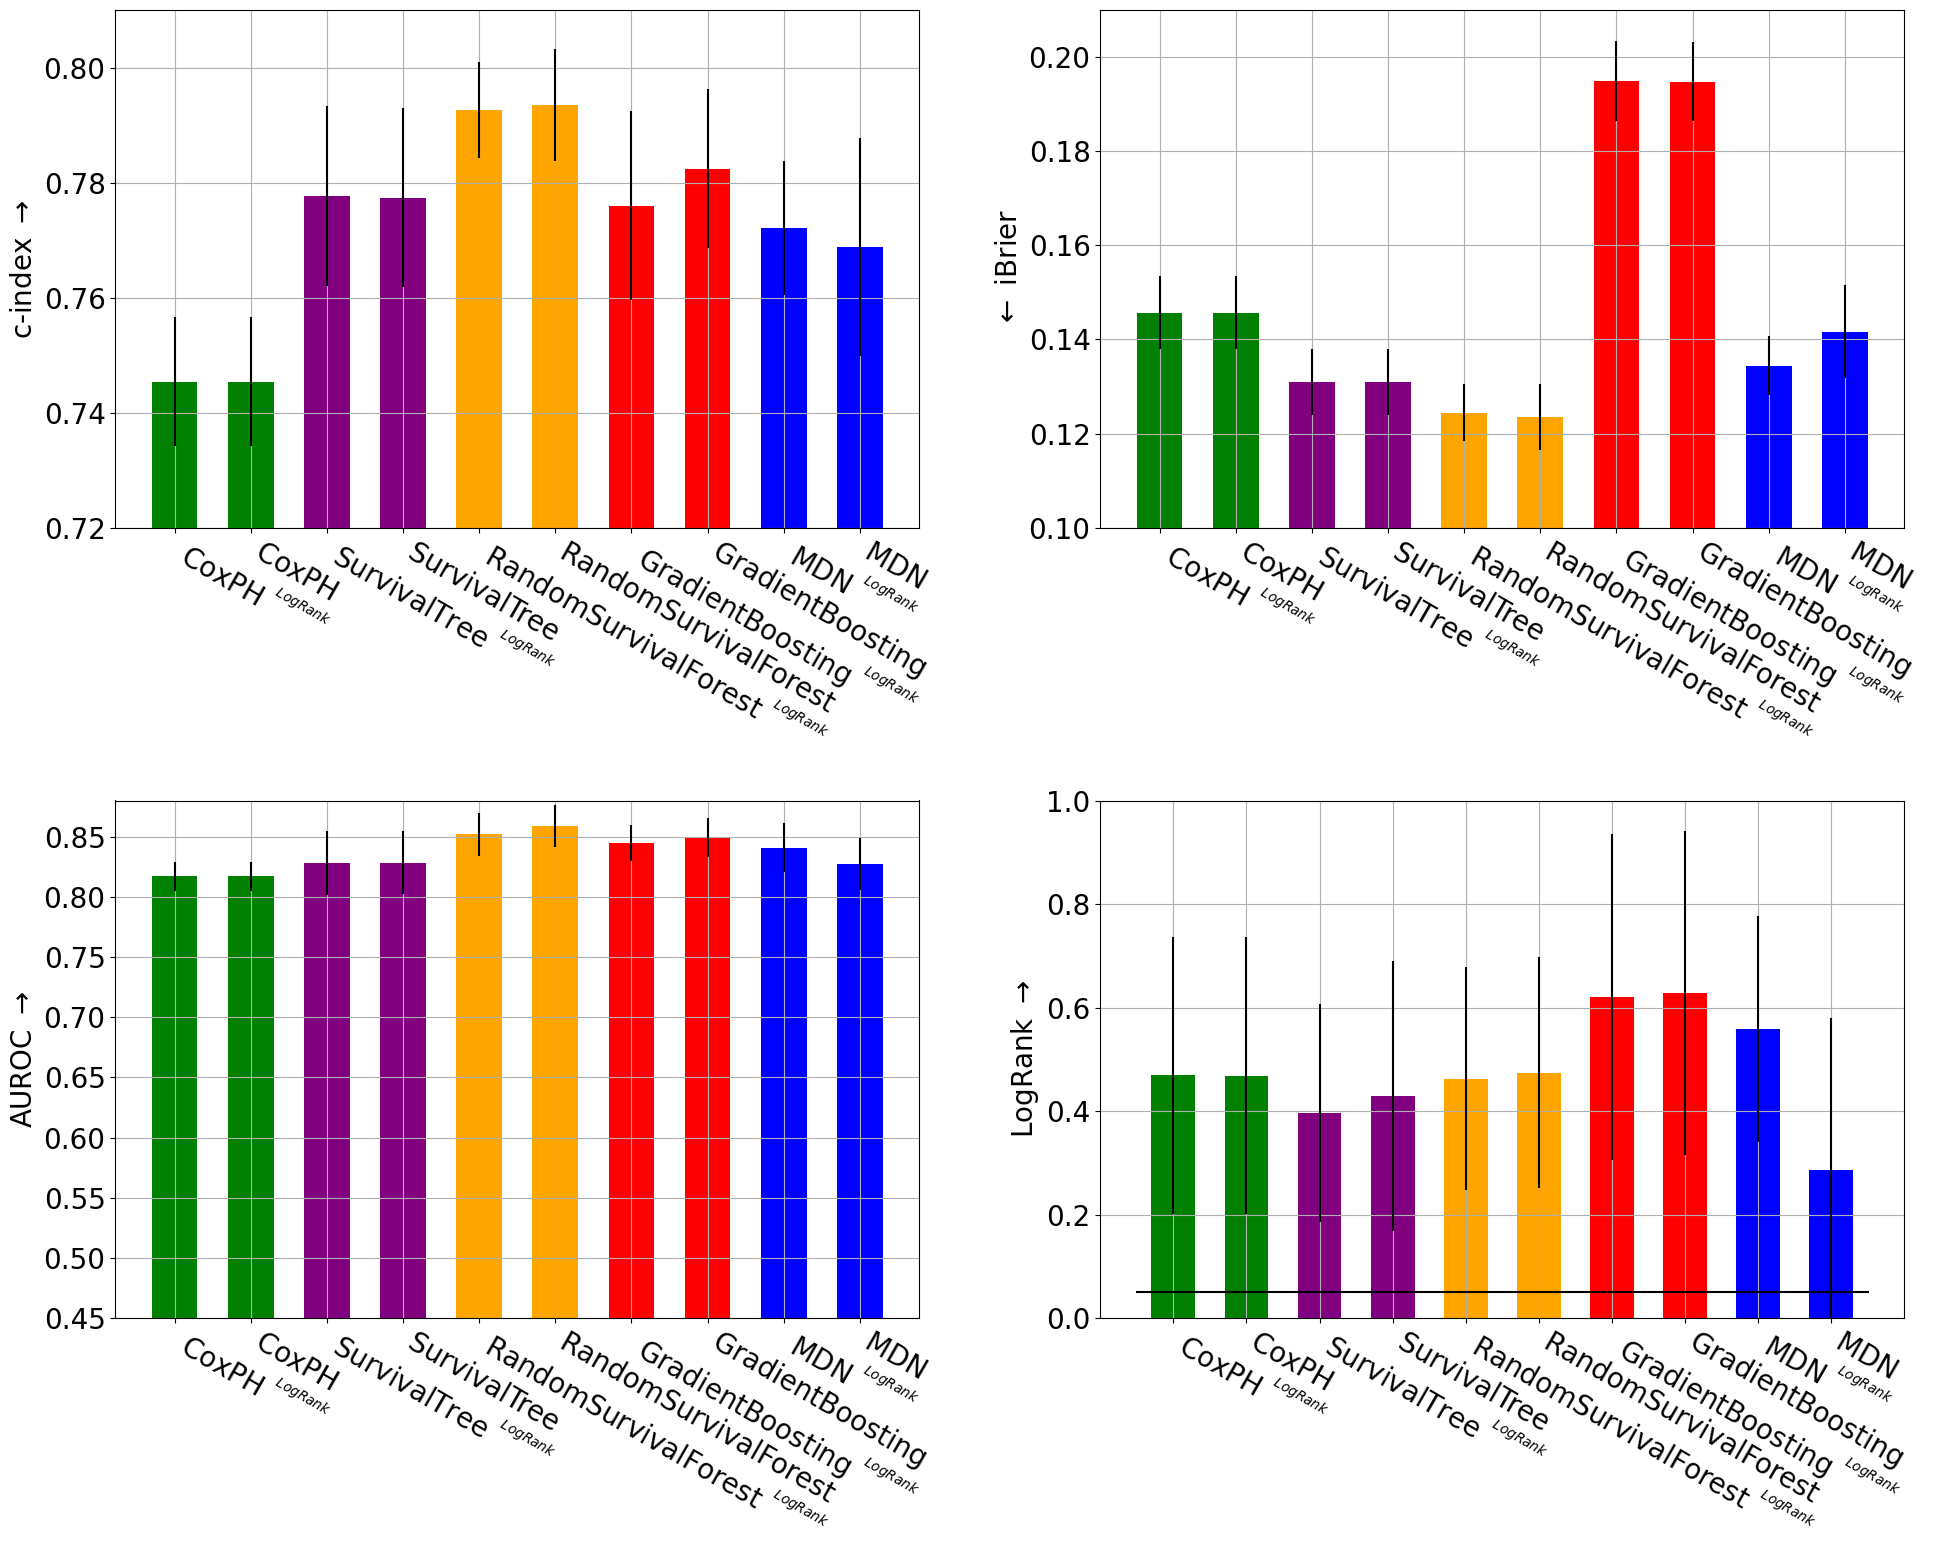

In [25]:
typ = "5Fold"

fig, axs = plt.subplots(2,2,figsize=(20,16))
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
locs = [[0,0],[0,1],[1,0],[1,1]]
ylims = [[0.72,0.81],[0.1,0.21],[0.45,0.88],[0,1]]

for scr,loc,ylim in zip(scores,locs,ylims):
    for _,row in main_results_plot[(main_results_plot.Type == typ) & (main_results_plot.Score == scr)].iterrows():
        b = axs[loc[0]][loc[1]].bar(row.Model, height = row["mean"],width = 0.6, yerr = row["std"], color = row.Color)  
    if scr == "LogRank $\\rightarrow$":
        #axs[loc[0]][loc[1]].set_yscale("log")
        axs[loc[0]][loc[1]].plot(np.linspace(-0.5,9.5,100),0.05*np.ones(100),marker = "", color = "black", label = "LogRank success > 0.05")
    #axs[loc[0]][loc[1]].tick_params(axis='x', labelrotation=-45, length = 40)
    axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
    if scr == "UnoC $\\rightarrow$":
        axs[loc[0]][loc[1]].set_ylabel("c-index $\\rightarrow$")
    else:
        axs[loc[0]][loc[1]].set_ylabel(scr)
    axs[loc[0]][loc[1]].set_ylim((ylim[0],ylim[1]))
    axs[loc[0]][loc[1]].grid("x")

#_ = fig.suptitle(f"{NAME_PLOT} advantage of LogRank optimization {typ} scores")
fig.tight_layout()

### Hold-out

C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_14572\850489205.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_14572\850489205.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_14572\850489205.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
C:\Users\kutato17\AppData\Local\Temp\4\ipykernel_14572\850489205.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")


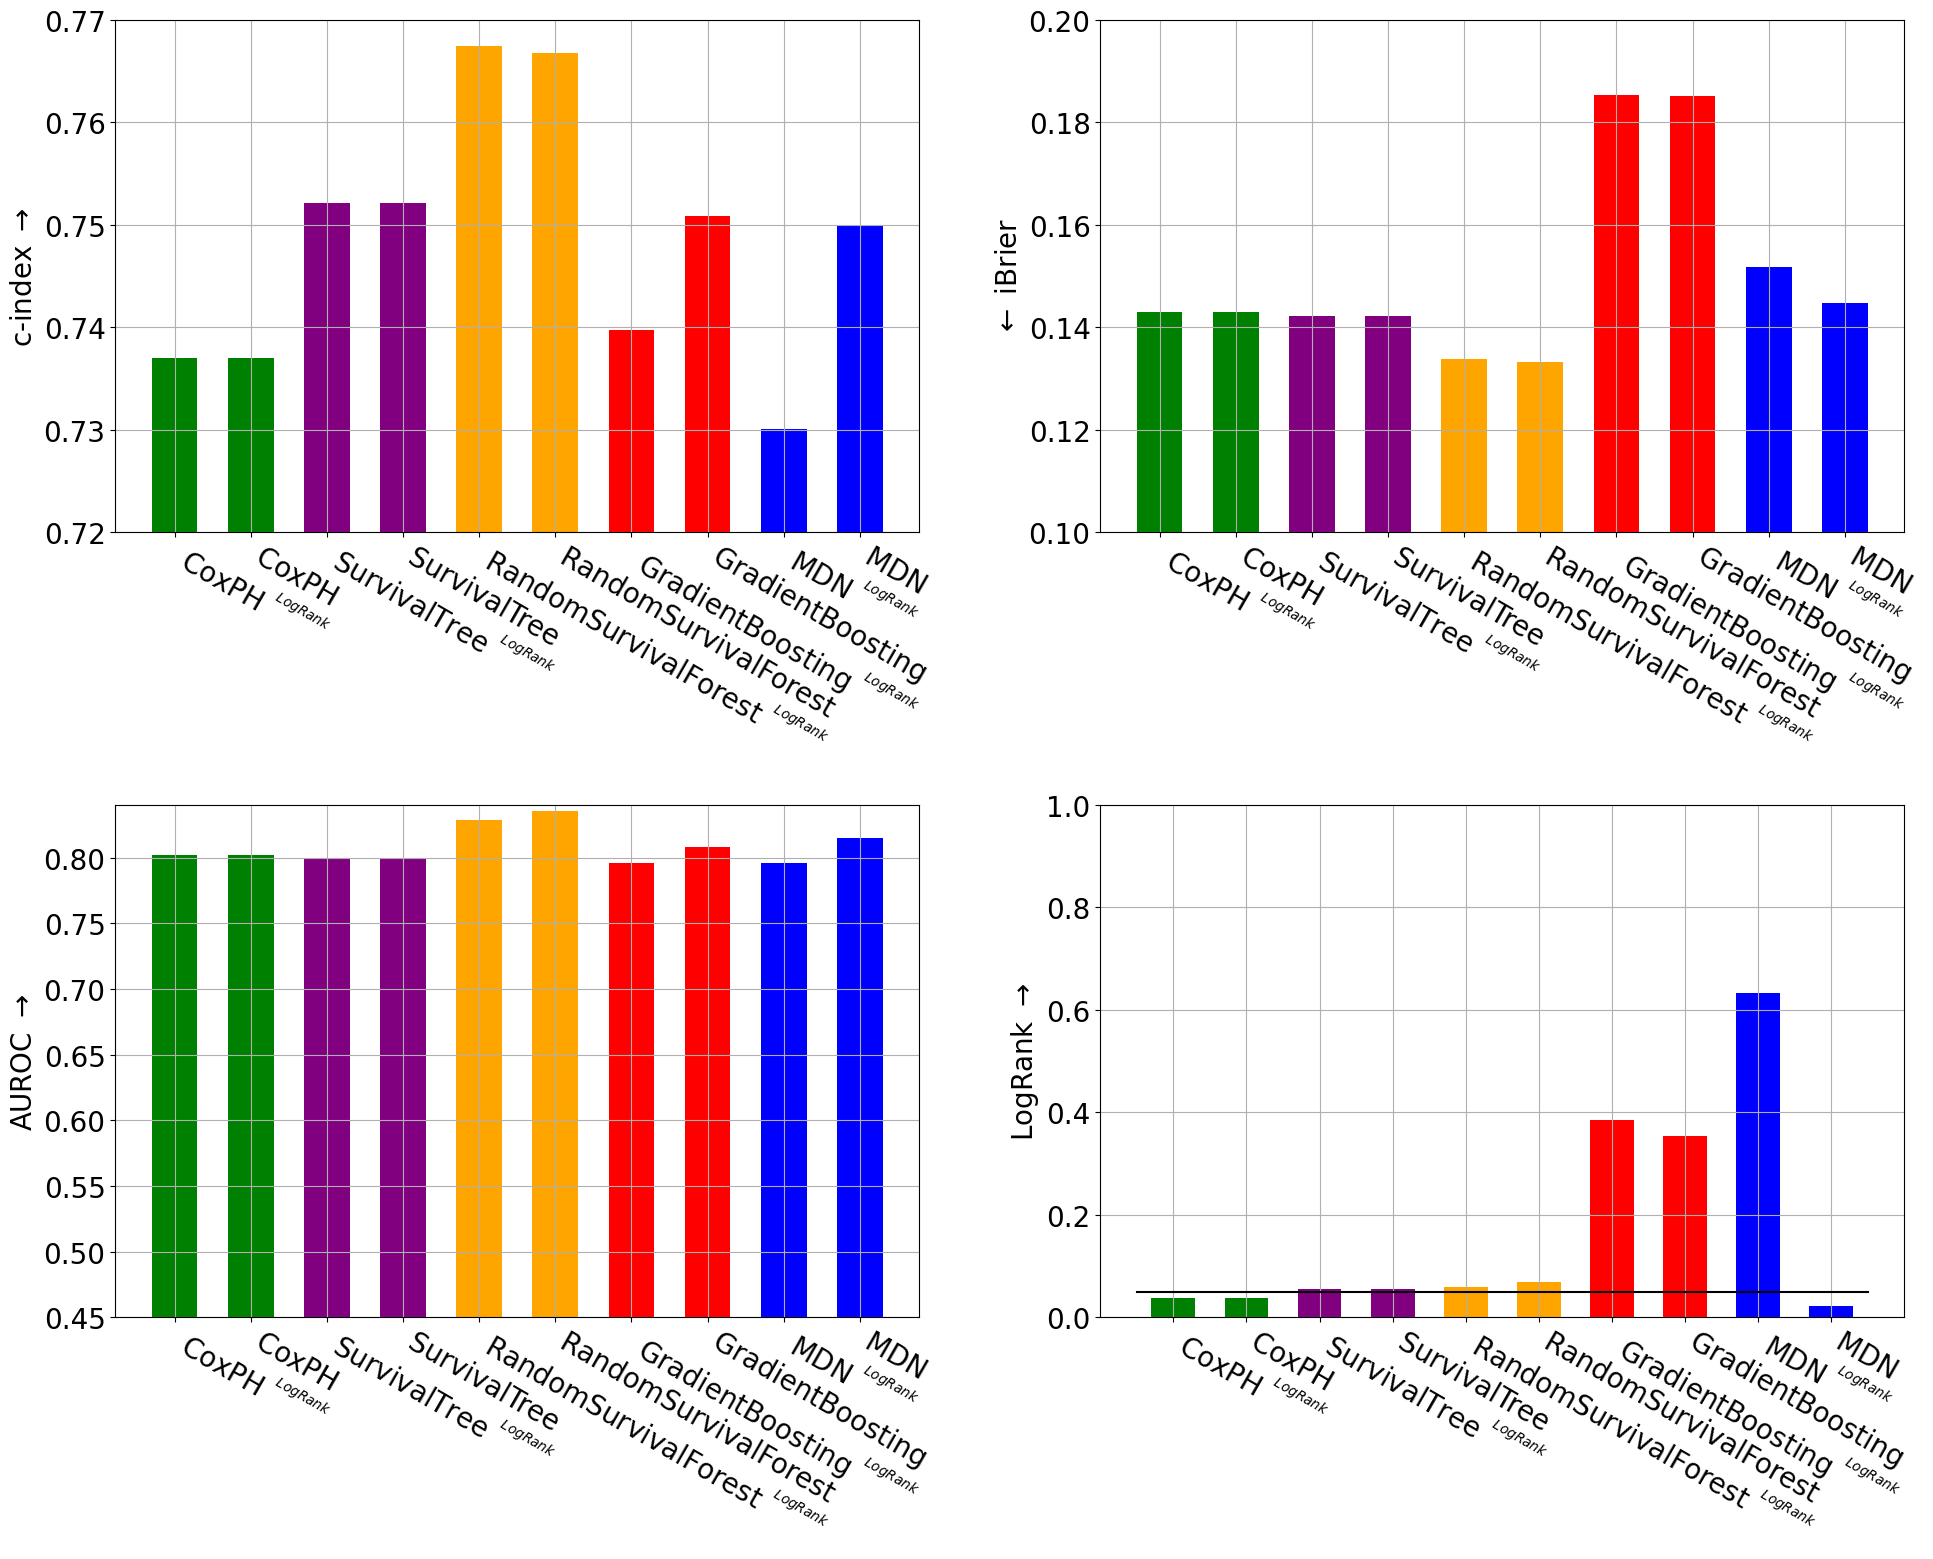

In [26]:
typ = "Hold-out"

fig, axs = plt.subplots(2,2,figsize=(20,16))
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
locs = [[0,0],[0,1],[1,0],[1,1]]
ylims = [[0.72,0.77],[0.1,0.2],[0.45,0.84],[0,1]]

for scr,loc,ylim in zip(scores,locs,ylims):
    for _,row in main_results_plot[(main_results_plot.Type == typ) & (main_results_plot.Score == scr)].iterrows():
        b = axs[loc[0]][loc[1]].bar(row.Model, height = row["mean"],width = 0.6, yerr = row["std"], color = row.Color)  
    if scr == "LogRank $\\rightarrow$":
        #axs[loc[0]][loc[1]].set_yscale("log")
        axs[loc[0]][loc[1]].plot(np.linspace(-0.5,9.5,100),0.05*np.ones(100),marker = "", color = "black", label = "LogRank success > 0.05")
    #axs[loc[0]][loc[1]].tick_params(axis='x', labelrotation=-45)
    axs[loc[0]][loc[1]].set_xticklabels(main_results_plot.Model.unique(),rotation = -30, ha = "left")
    if scr == "UnoC $\\rightarrow$":
        axs[loc[0]][loc[1]].set_ylabel("c-index $\\rightarrow$")
    else:
        axs[loc[0]][loc[1]].set_ylabel(scr)
    axs[loc[0]][loc[1]].set_ylim((ylim[0],ylim[1]))
    axs[loc[0]][loc[1]].grid("x")

#_ = fig.suptitle(f"{NAME_PLOT} advantage of LogRank optimization {typ} scores")
fig.tight_layout()#rect=[0, 0.03, 1, 0.99])

## Compare Survival functions

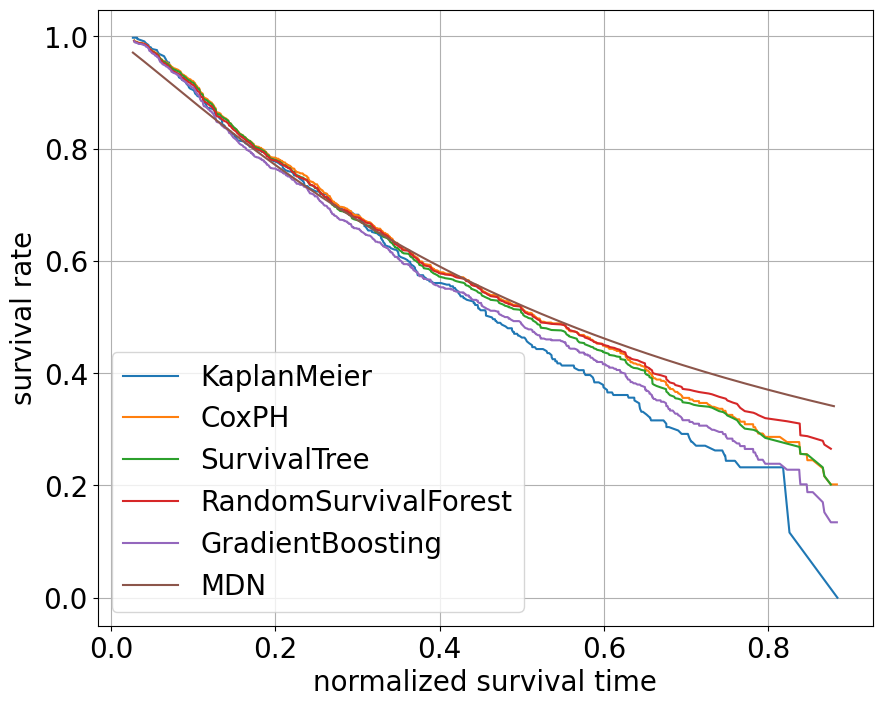

In [27]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True]
trials = list(product(models,opts))

compare_survival  = {"Model":[],
                     "Timeline":[],
                     "Survival_Function":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == 1.0):
            compare_survival["Model"].append(f"{trial[0]}")
            compare_survival["Timeline"].append(results_table["Timeline"][i])
            compare_survival["Survival_Function"].append(results_table["Overall_Survival_Function"][i])
            

plt.figure(figsize=(10,8))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]
km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(km_timeline,km_prob_survival, label = "KaplanMeier")

for i in range(len(compare_survival["Model"])):
    plt.plot(compare_survival["Timeline"][i], compare_survival["Survival_Function"][i], label = compare_survival["Model"][i])
plt.legend()
plt.grid()
#plt.title(f"Survival rate estimate for the population of the {NAME_PLOT} hold-out set")
plt.xlabel("normalized survival time")
plt.ylabel("survival rate")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

## Sensitivity analysis
### Stratify by Score & Quantile

In [28]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
opts = [True]
T_maxs = [0.25,0.5,0.75,1.0]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,T_maxs,typs,scores))

sensitivity_analysis_  = {"Model":[],
                         "Color":[],
                         "Legend":[],
                         "Type":[],
                         "Score":[],
                         "T_max":[],
                         "Ts":[],
                         "means":[],
                         "stds":[]}

for trial in trials:
    sensitivity_analysis_["Model"].append(trial[0])
    sensitivity_analysis_["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    sensitivity_analysis_["Legend"].append(trial[0])
    sensitivity_analysis_["Type"].append(trial[3])
    if trial[4] == "iBrier":
        sensitivity_analysis_["Score"].append("$\\leftarrow$ " + trial[4])
    else:
        sensitivity_analysis_["Score"].append(trial[4] + " $\\rightarrow$")
    sensitivity_analysis_["T_max"].append(trial[2])

    ts = []
    means = []
    stds = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == trial[2]):
            ts.append([(results_table["Uncensored_Reduction"][i]-0.05) if results_table["Model"][i] == "CoxPH" else
                       (results_table["Uncensored_Reduction"][i]-0.025) if results_table["Model"][i] == "SurvivalTree" else
                       (results_table["Uncensored_Reduction"][i]) if results_table["Model"][i] == "RandomSurvivalForest" else
                       (results_table["Uncensored_Reduction"][i]+0.025) if results_table["Model"][i] == "GradientBoosting" else
                       (results_table["Uncensored_Reduction"][i]+0.05) if results_table["Model"][i] == "MDN" else
                       results_table["Uncensored_Reduction"][i]
                      ][0])

            if trial[3] == "5Fold":
                means.append(results_table[trial[3]][trial[4]]["mean"][i])
                stds.append(1.96*results_table[trial[3]][trial[4]]["std"][i]/np.sqrt(5))
            else:
                means.append(results_table[trial[3]][trial[4]][i])
                stds.append(0)

    sensitivity_analysis_["Ts"].append(ts)
    sensitivity_analysis_["means"].append(means)
    sensitivity_analysis_["stds"].append(stds)

sensitivity_analysis_ = pd.DataFrame.from_dict(sensitivity_analysis_)

### Heatmap

In [29]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["Green","Purple","Orange","Red","Blue"]
markers = ["o","v","s","D","*"]
opts = [True]
typs = ["5Fold","Hold-out"]
scores = ["UnoC","iBrier","AUROC","LogRank"]
trials = list(product(models,opts,typs,scores))

sensitivity_analysis_heatmap  = {"Model":[],
                         "Color":[],
                         "Marker":[],
                         "Type":[],
                         "Score":[],
                         "xs":[],
                         "ys":[],
                         "means":[],
                         "stds":[]}

for trial in trials:
    sensitivity_analysis_heatmap["Model"].append(trial[0])
    sensitivity_analysis_heatmap["Color"].append([item[1] for item in zip(models,colors) if item[0] == trial[0]][0])
    sensitivity_analysis_heatmap["Marker"].append([item[1] for item in zip(models,markers) if item[0] == trial[0]][0])
    sensitivity_analysis_heatmap["Type"].append(trial[2])
    if trial[3] == "iBrier":
        sensitivity_analysis_heatmap["Score"].append("$\\leftarrow$ " + trial[3])
    else:
        sensitivity_analysis_heatmap["Score"].append(trial[3] + " $\\rightarrow$")
    #colors = []
    xs = []
    ys = []
    means = []
    stds = []
    for i in range(len(results_table["Model"])):
        if ((results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1])):
            xs.append(results_table["Uncensored_Reduction"][i])
            ys.append(results_table["T_max"][i])
            if trial[2] == "5Fold":
                means.append(results_table[trial[2]][trial[3]]["mean"][i])
                stds.append(1.96*results_table[trial[2]][trial[3]]["std"][i]/np.sqrt(5))
            else:
                means.append(results_table[trial[2]][trial[3]][i])
                stds.append(0)

    sensitivity_analysis_heatmap["xs"].append(xs)
    sensitivity_analysis_heatmap["ys"].append(ys)
    sensitivity_analysis_heatmap["means"].append(means)
    sensitivity_analysis_heatmap["stds"].append(stds)

sensitivity_analysis_heatmap = pd.DataFrame.from_dict(sensitivity_analysis_heatmap)

### Plots
#### 5Fold

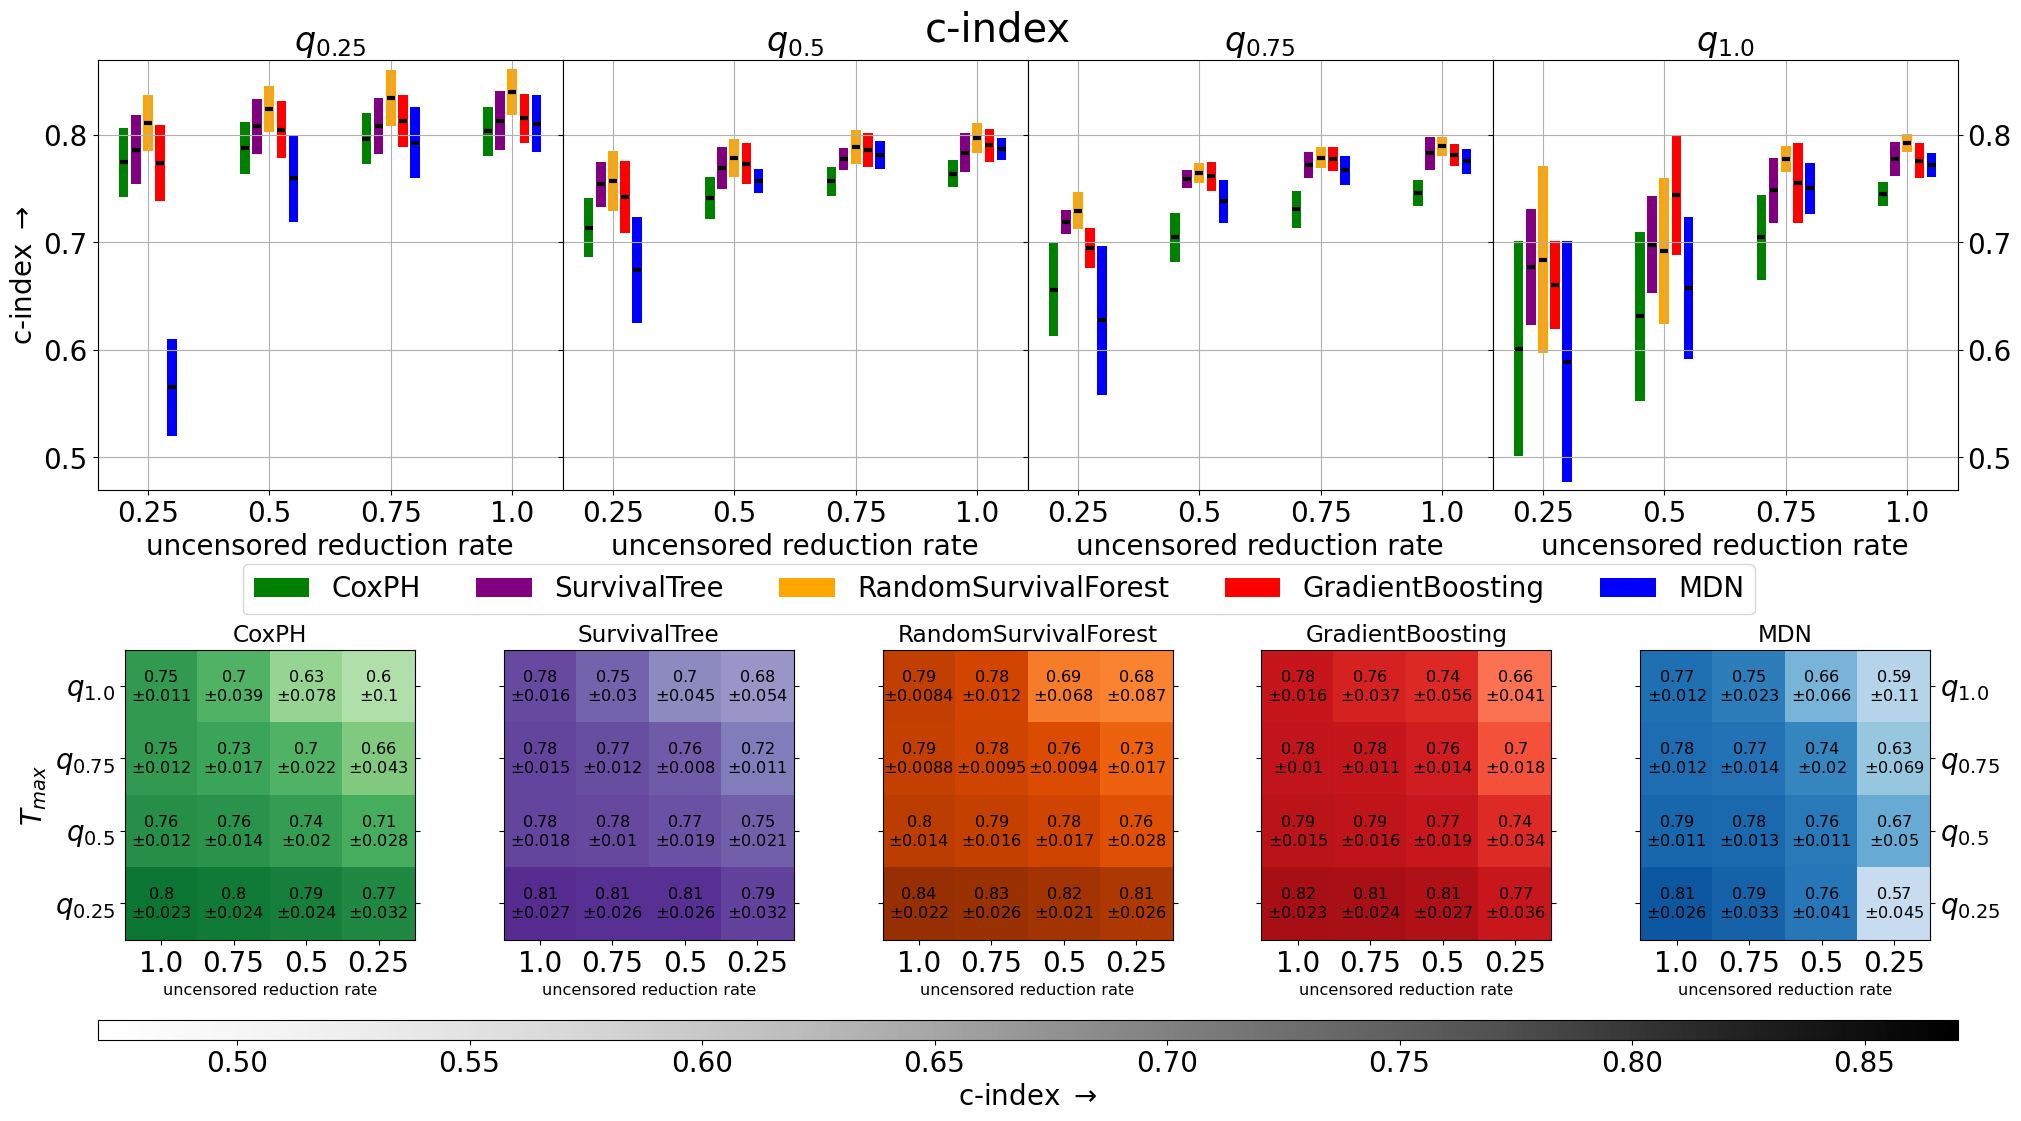

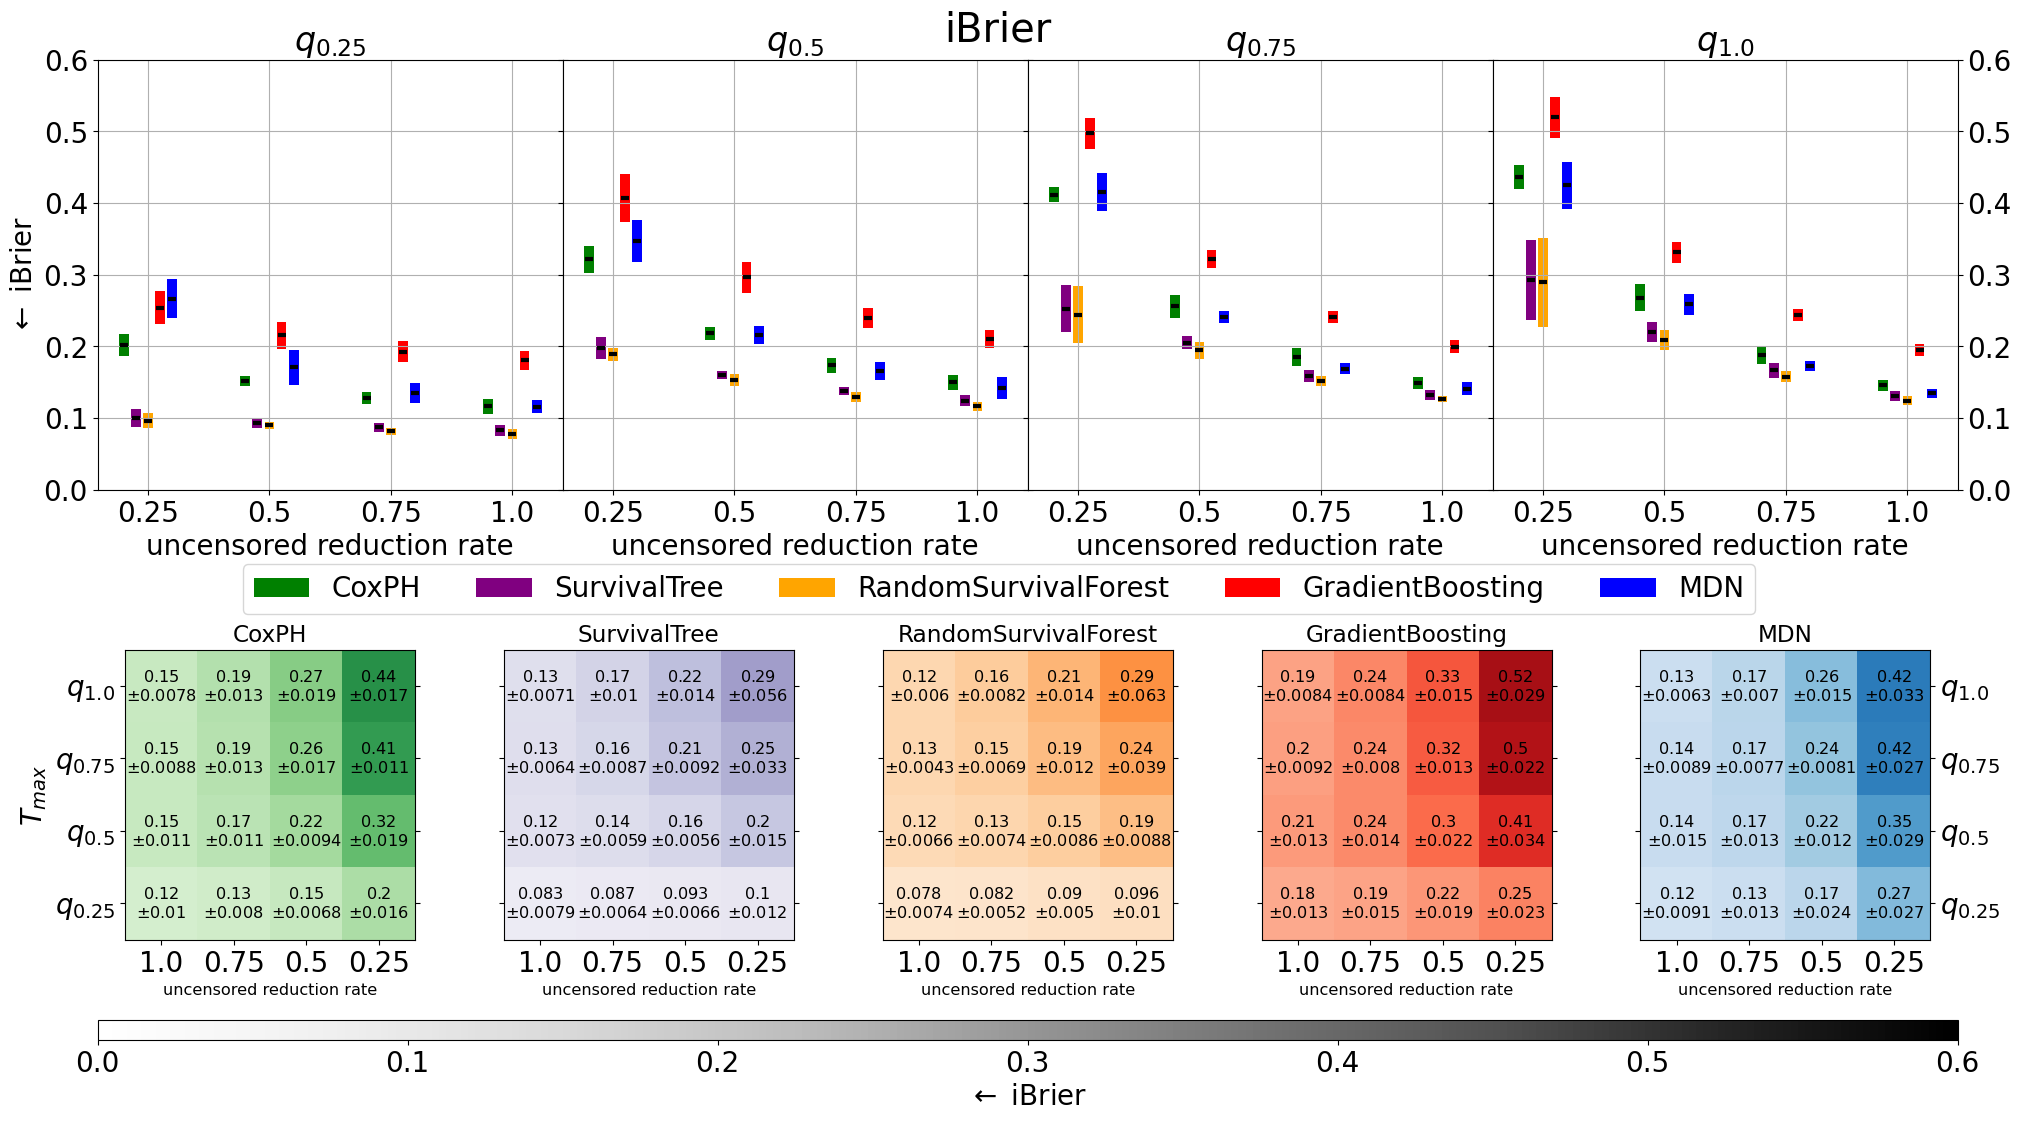

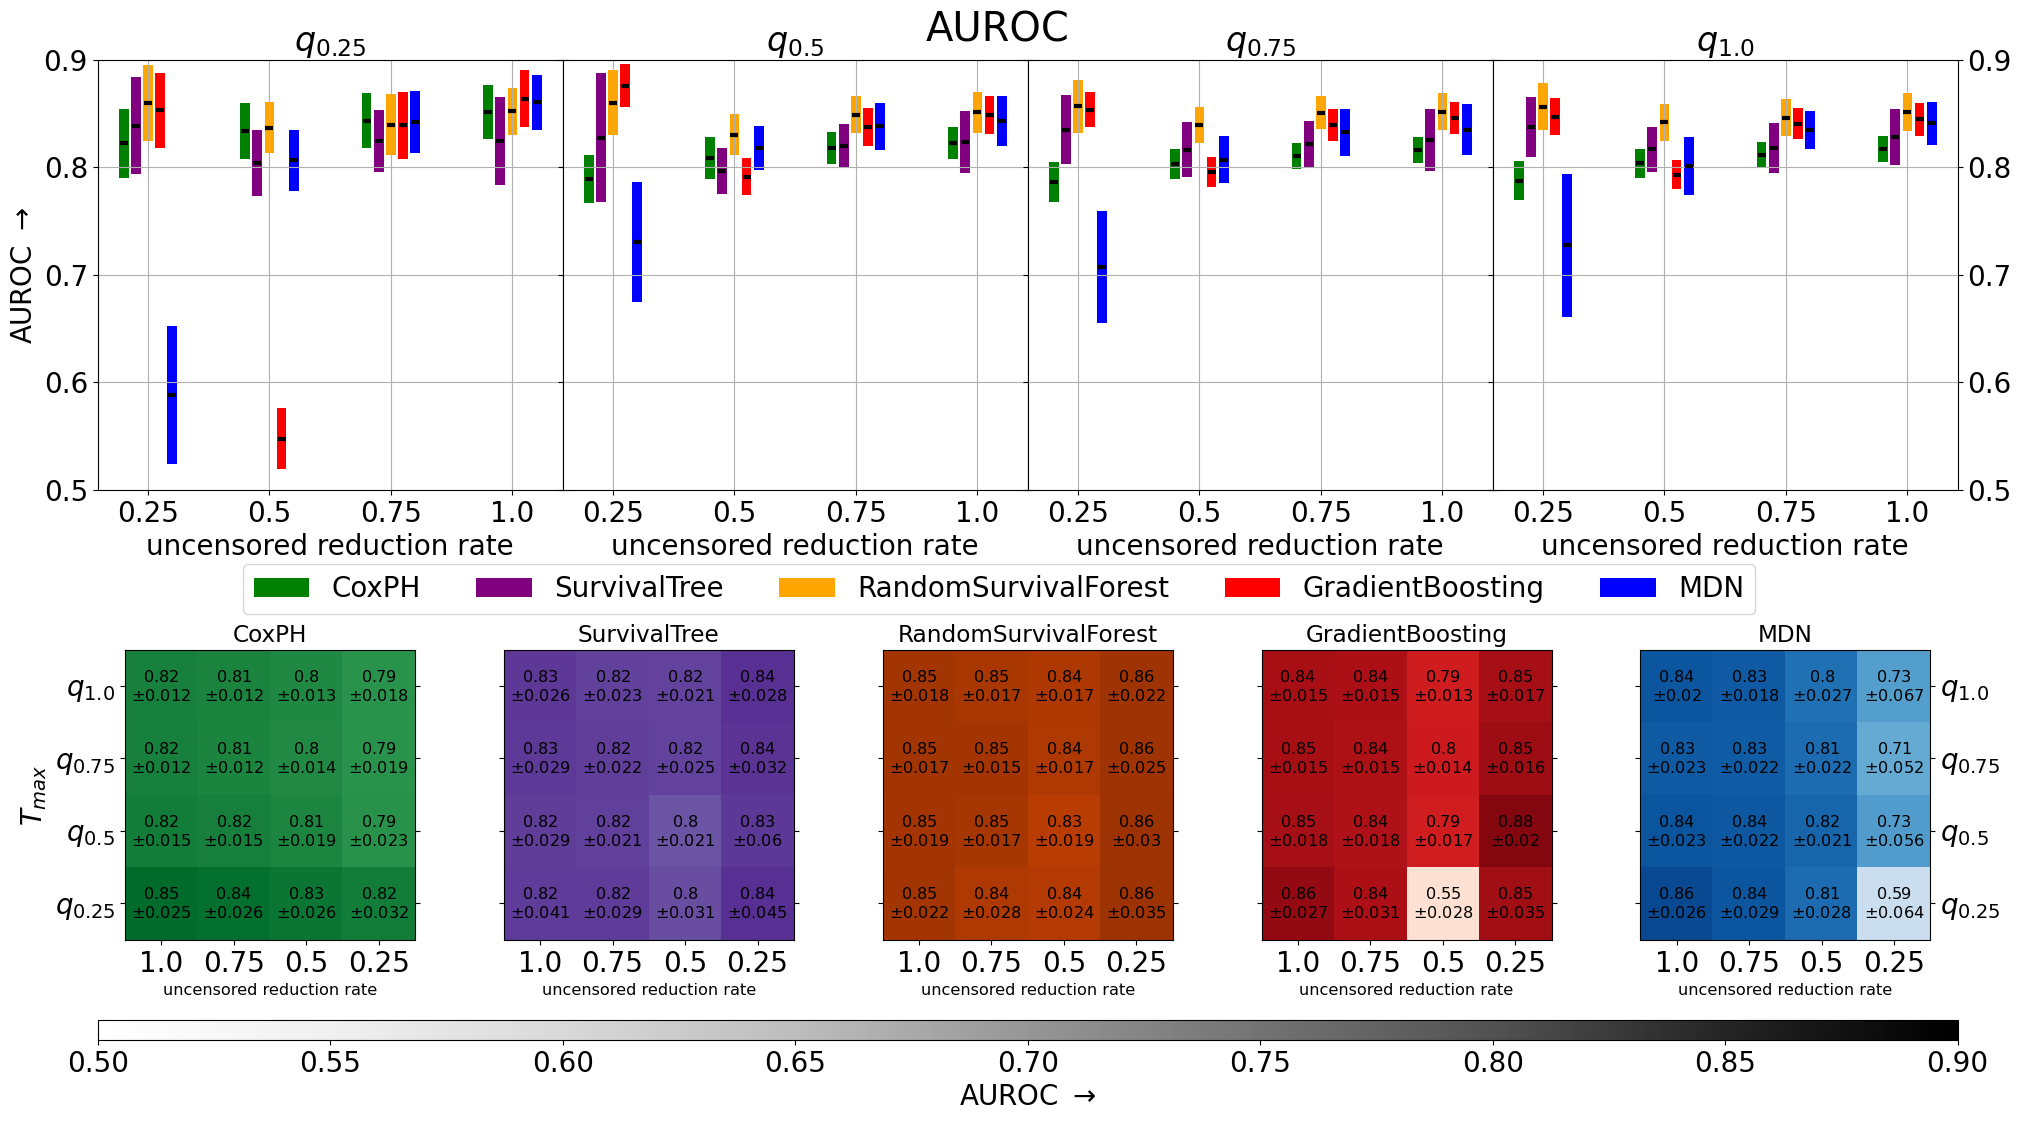

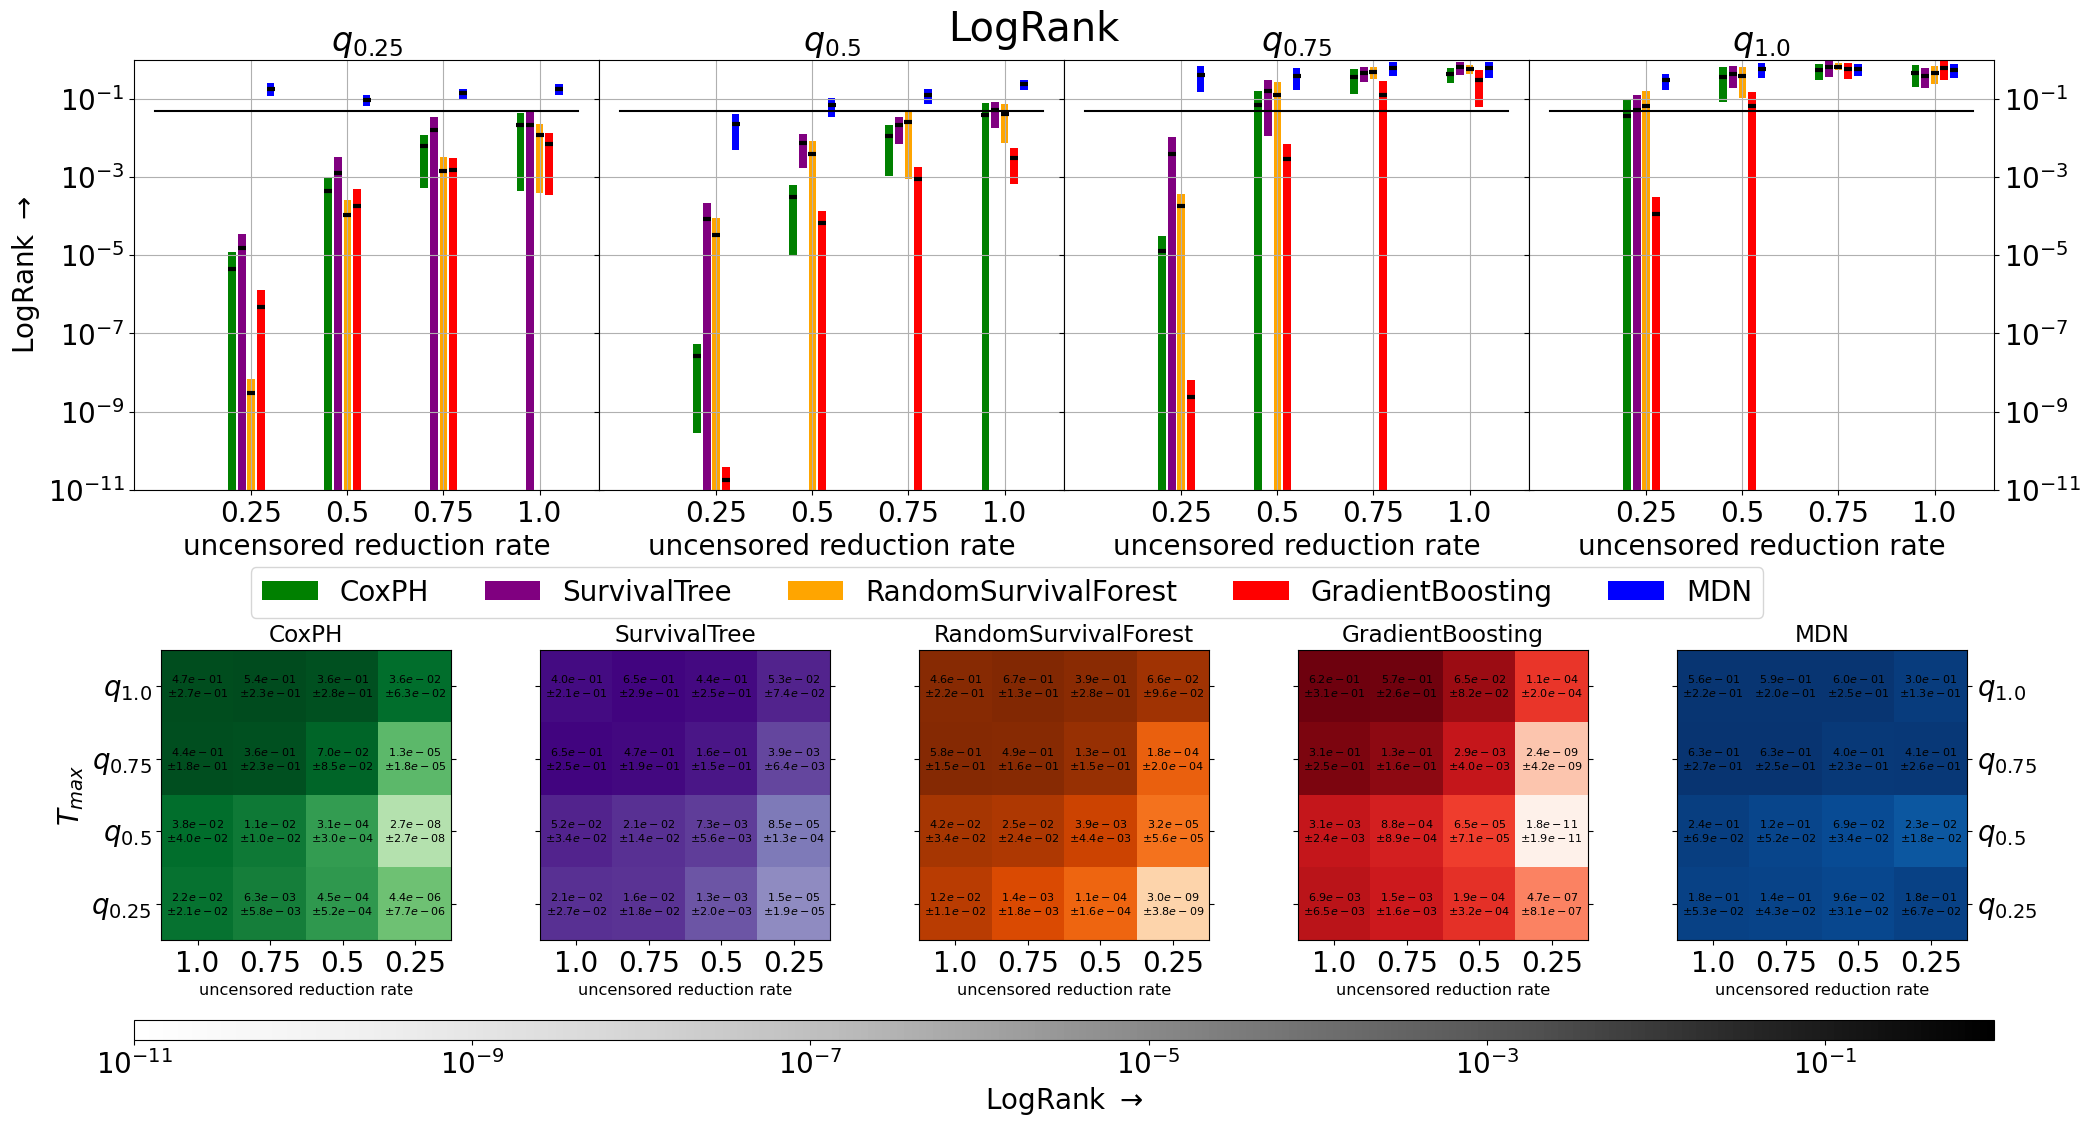

In [30]:
typ = "5Fold"
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
score_names = ["c-index","iBrier","AUROC","LogRank"]
ylims = [[0.47,0.87],[0.,0.6],[0.5,0.9],[1e-11,1]]

for scr,scr_nm,ylim in zip(scores,score_names,ylims):
    #print(scr)
    fig = plt.figure(figsize=(20,10))

    # GridSpec for the barplots
    gs1 = GridSpec(1, 4, figure = fig, bottom=0.55, top=0.98, left=0.05, right=0.98, wspace = 0.0)
    bar_axs = []
    bar_locs = [0,1,2,3]
    for loc in bar_locs:
        bar_axs.append(fig.add_subplot(gs1[loc]))

    T_maxs = [0.25,0.5,0.75,1.0]
    for loc,T_max in zip(bar_locs,T_maxs):
        for _,row in sensitivity_analysis_[(sensitivity_analysis_.Type == typ) & (sensitivity_analysis_.Score == scr) & (sensitivity_analysis_.T_max == T_max)].iterrows():
            # Do the Japanese candles
            bar_axs[loc].plot(row["Ts"], row["means"], ls = "", marker = "_", markeredgewidth = 3, color = "black")
            bar_axs[loc].bar(row["Ts"], height = np.array(row["stds"])*2,width = 0.02, bottom = np.array(row["means"]) - np.array(row["stds"]), color = row.Color, label = row["Model"])

        if scr == "LogRank $\\rightarrow$":
            bar_axs[loc].set_yscale("log")
            bar_axs[loc].plot(np.linspace(0,1.1,100),0.05*np.ones(100),marker = "", color = "black")#, label = "LogRank success > 0.05")

        bar_axs[loc].set_xticks([0.25,0.5,0.75,1.0],["0.25","0.5","0.75","1.0"])
        bar_axs[loc].set_xlabel("uncensored reduction rate")
        if scr == "UnoC $\\rightarrow$":
            bar_axs[loc].set_ylabel("c-index $\\rightarrow$")
        else:
            bar_axs[loc].set_ylabel(scr)
        bar_axs[loc].yaxis.set_ticks_position('both')
        bar_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
        bar_axs[loc].set_ylim((ylim[0],ylim[1]))
        bar_axs[loc].grid()
        bar_axs[loc].set_title("$q_{" + f"{T_max}" +"}$")
        bar_axs[loc].label_outer()

    # GridSpec for the Heatmaps
    gs2 = GridSpec(1,5, figure = fig, bottom=0.1, top=0.39, left=0.05, right=0.98, wspace = 0.1)
    heat_axs = []
    heat_locs = [0,1,2,3,4]
    for loc in heat_locs:
        heat_axs.append(fig.add_subplot(gs2[loc]))
    # GridSpec for the Colorbar
    gs3 = GridSpec(1,1, figure = fig, bottom=0.00, top=0.02, left=0.05, right=0.98, wspace = 0.1)
    cbar_ax = fig.add_subplot(gs3[0])

    models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
    for loc,model in zip(heat_locs,models):
        for _,row in sensitivity_analysis_heatmap[(sensitivity_analysis_heatmap.Model == model) & (sensitivity_analysis_heatmap.Type == typ) & (sensitivity_analysis_heatmap.Score == scr)].iterrows():
            # Normalization
            if scr == "LogRank $\\rightarrow$":
                norm = LogNorm(vmin = ylim[0], vmax = ylim[1])
            else:
                norm = Normalize(vmin = ylim[0], vmax = ylim[1])

            # Heatmap
            im = heat_axs[loc].imshow(np.array(row.means).reshape(4,4), norm = norm, cmap = f"{row.Color}s")

            # Colorbar
            if loc == heat_locs[-1]:
                cbar = fig.colorbar(ScalarMappable(cmap = "Greys", norm = norm), cax = cbar_ax, orientation='horizontal')
                # Colorbar labels
                if scr == "UnoC $\\rightarrow$":
                    cbar.set_label("c-index $\\rightarrow$")
                else:
                    cbar.set_label(scr)

            # Ticks & Tick labels
            heat_axs[loc].set_xticks(np.arange(np.array(row.means).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            heat_axs[loc].set_xlabel("uncensored reduction rate", fontsize = "xx-small")
            heat_axs[loc].set_yticks(np.arange(np.array(row.means).reshape(4,4).shape[0]), labels=["$q_{1.0}$","$q_{0.75}$","$q_{0.5}$","$q_{0.25}$"])
            heat_axs[loc].yaxis.set_ticks_position('both')
            heat_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
            heat_axs[loc].set_ylabel("$T_{max}$")
            heat_axs[loc].label_outer()

            heat_axs[loc].set_title(model, fontsize = "small")



            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    clr = "black"
                    if scr == "LogRank $\\rightarrow$":
                        #if np.array(row.means).reshape(4,4)[i,j] < 0.05:
                        #    clr = "red"
                        mean = "{:.1e}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.1e}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = 8
                    else:
                        mean = "{:.2}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.2}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = "xx-small"
                    if typ == "5Fold":
                        scr_str = f"${mean}$\n$\pm {std}$"
                    else:
                        scr_str = f"{mean}"
                    text = heat_axs[loc].text(j, i, scr_str,ha="center", va="center", size = text_size, color = clr)

    handles, labels = bar_axs[bar_locs[-1]].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.12,0.452),ncol = 5)
    fig.suptitle(scr_nm, y = 1.03, fontsize = "x-large")
    plt.show()

#### Hold-out

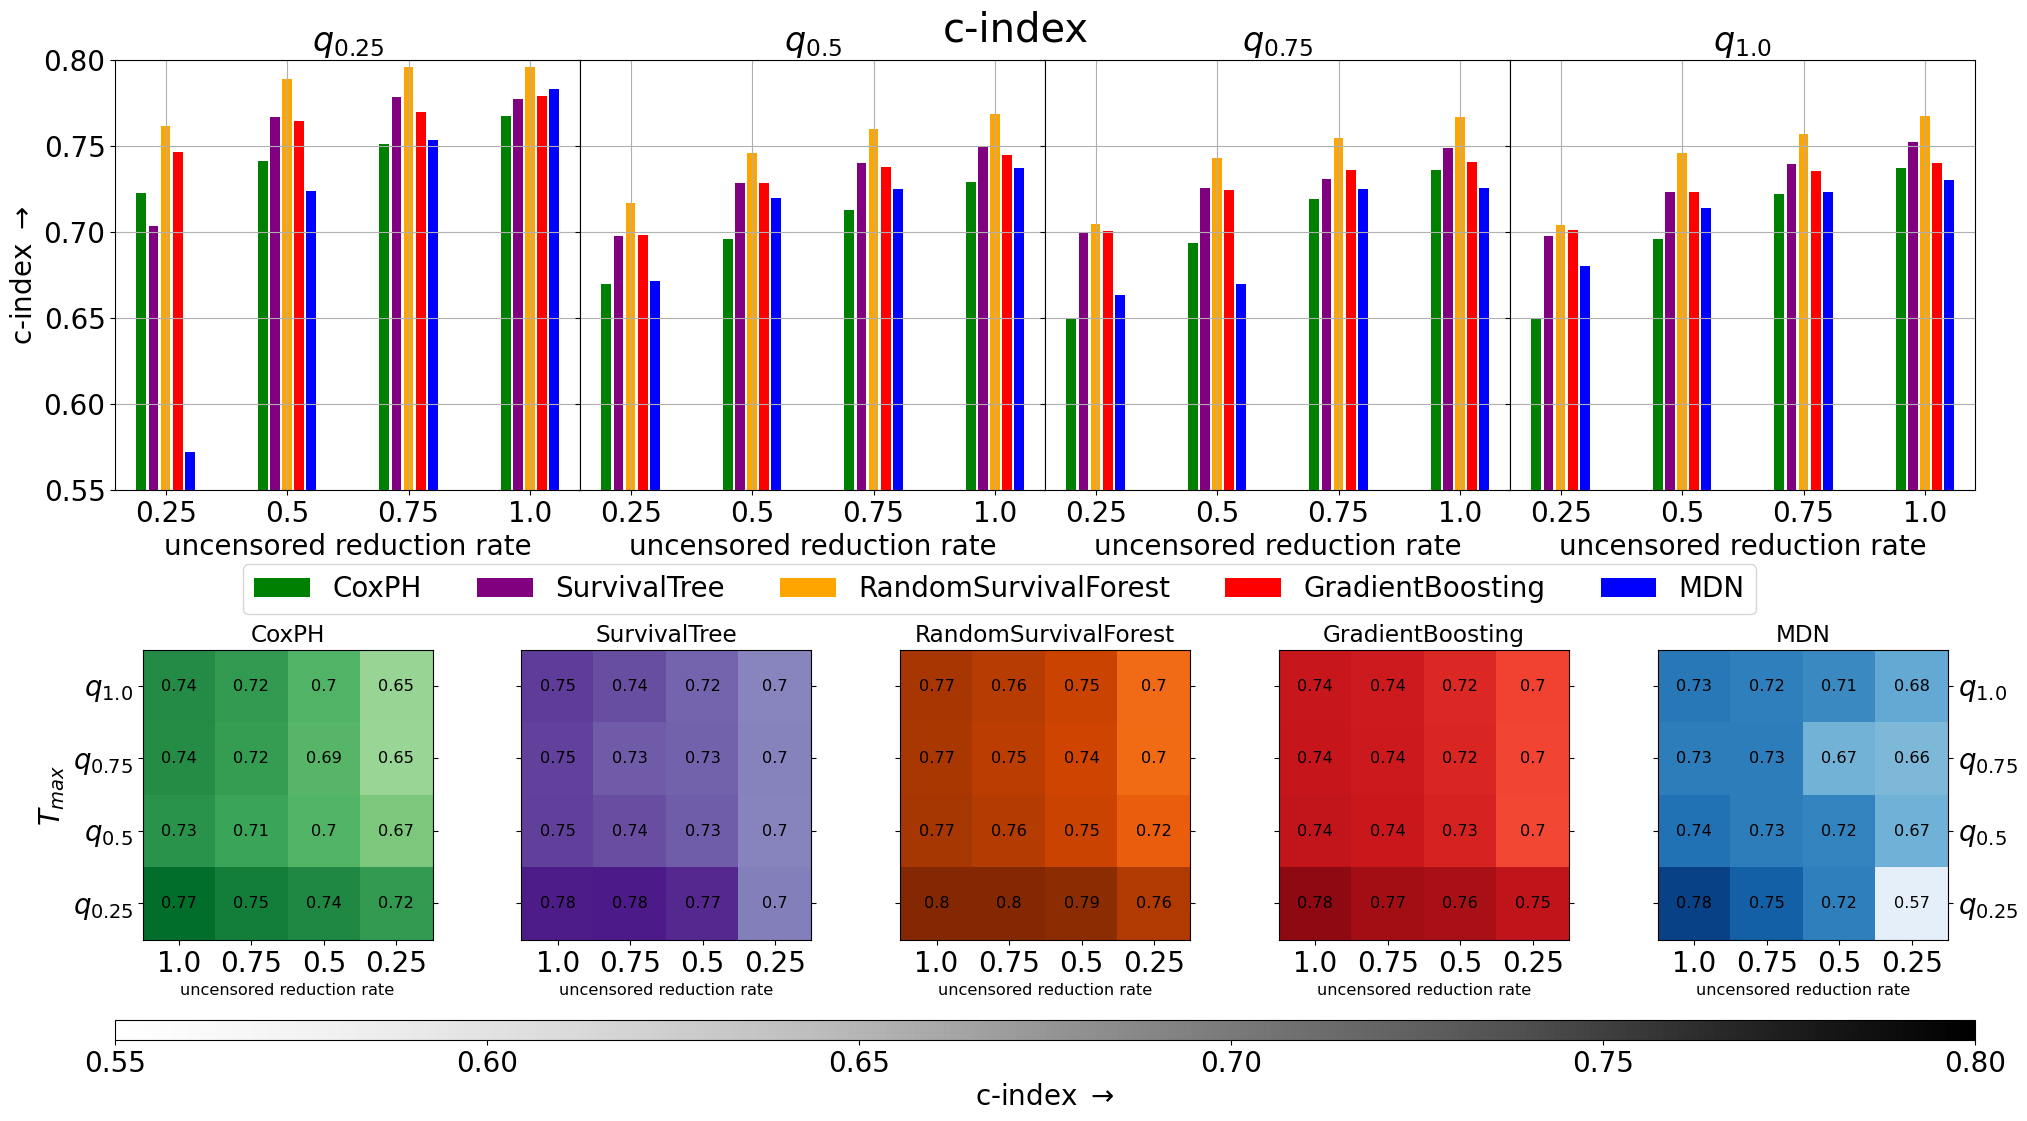

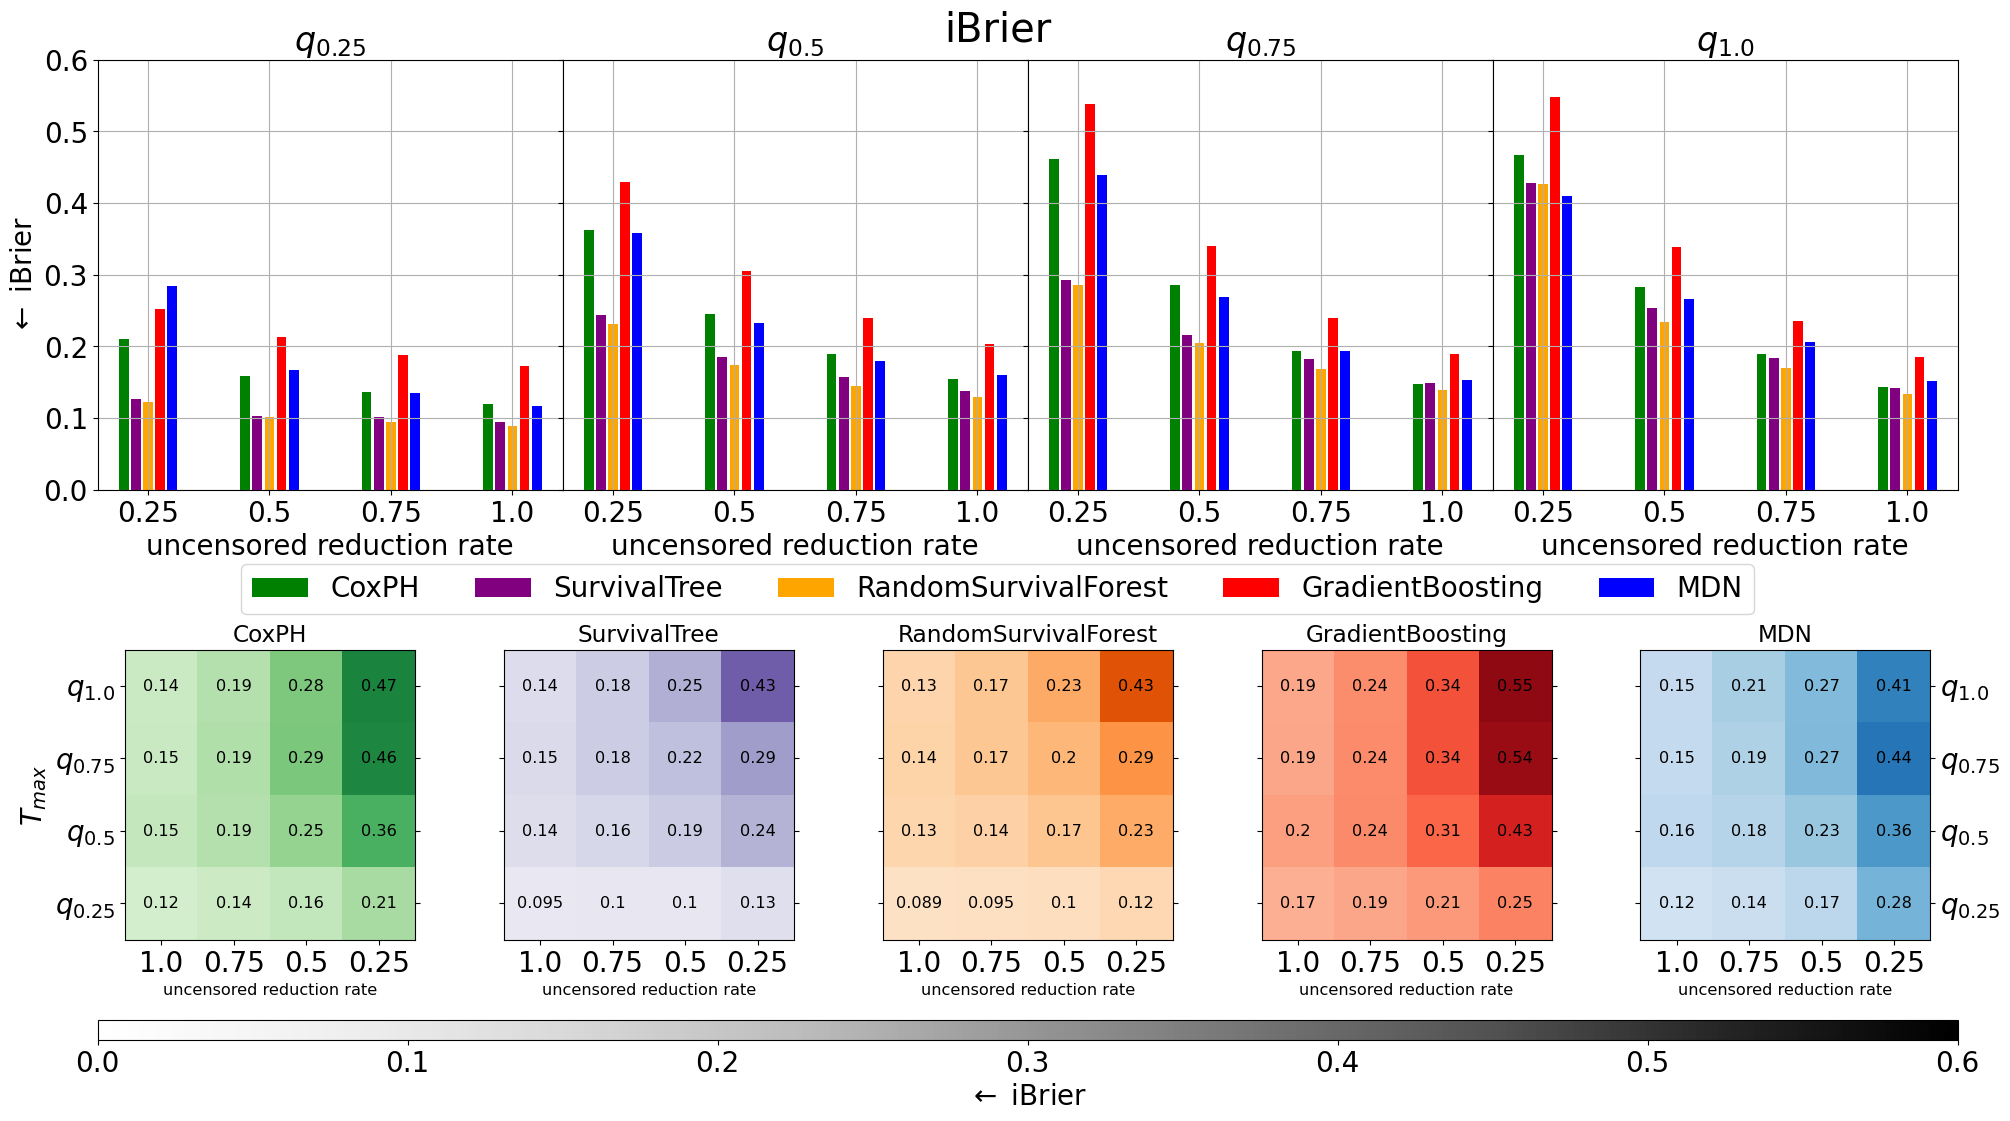

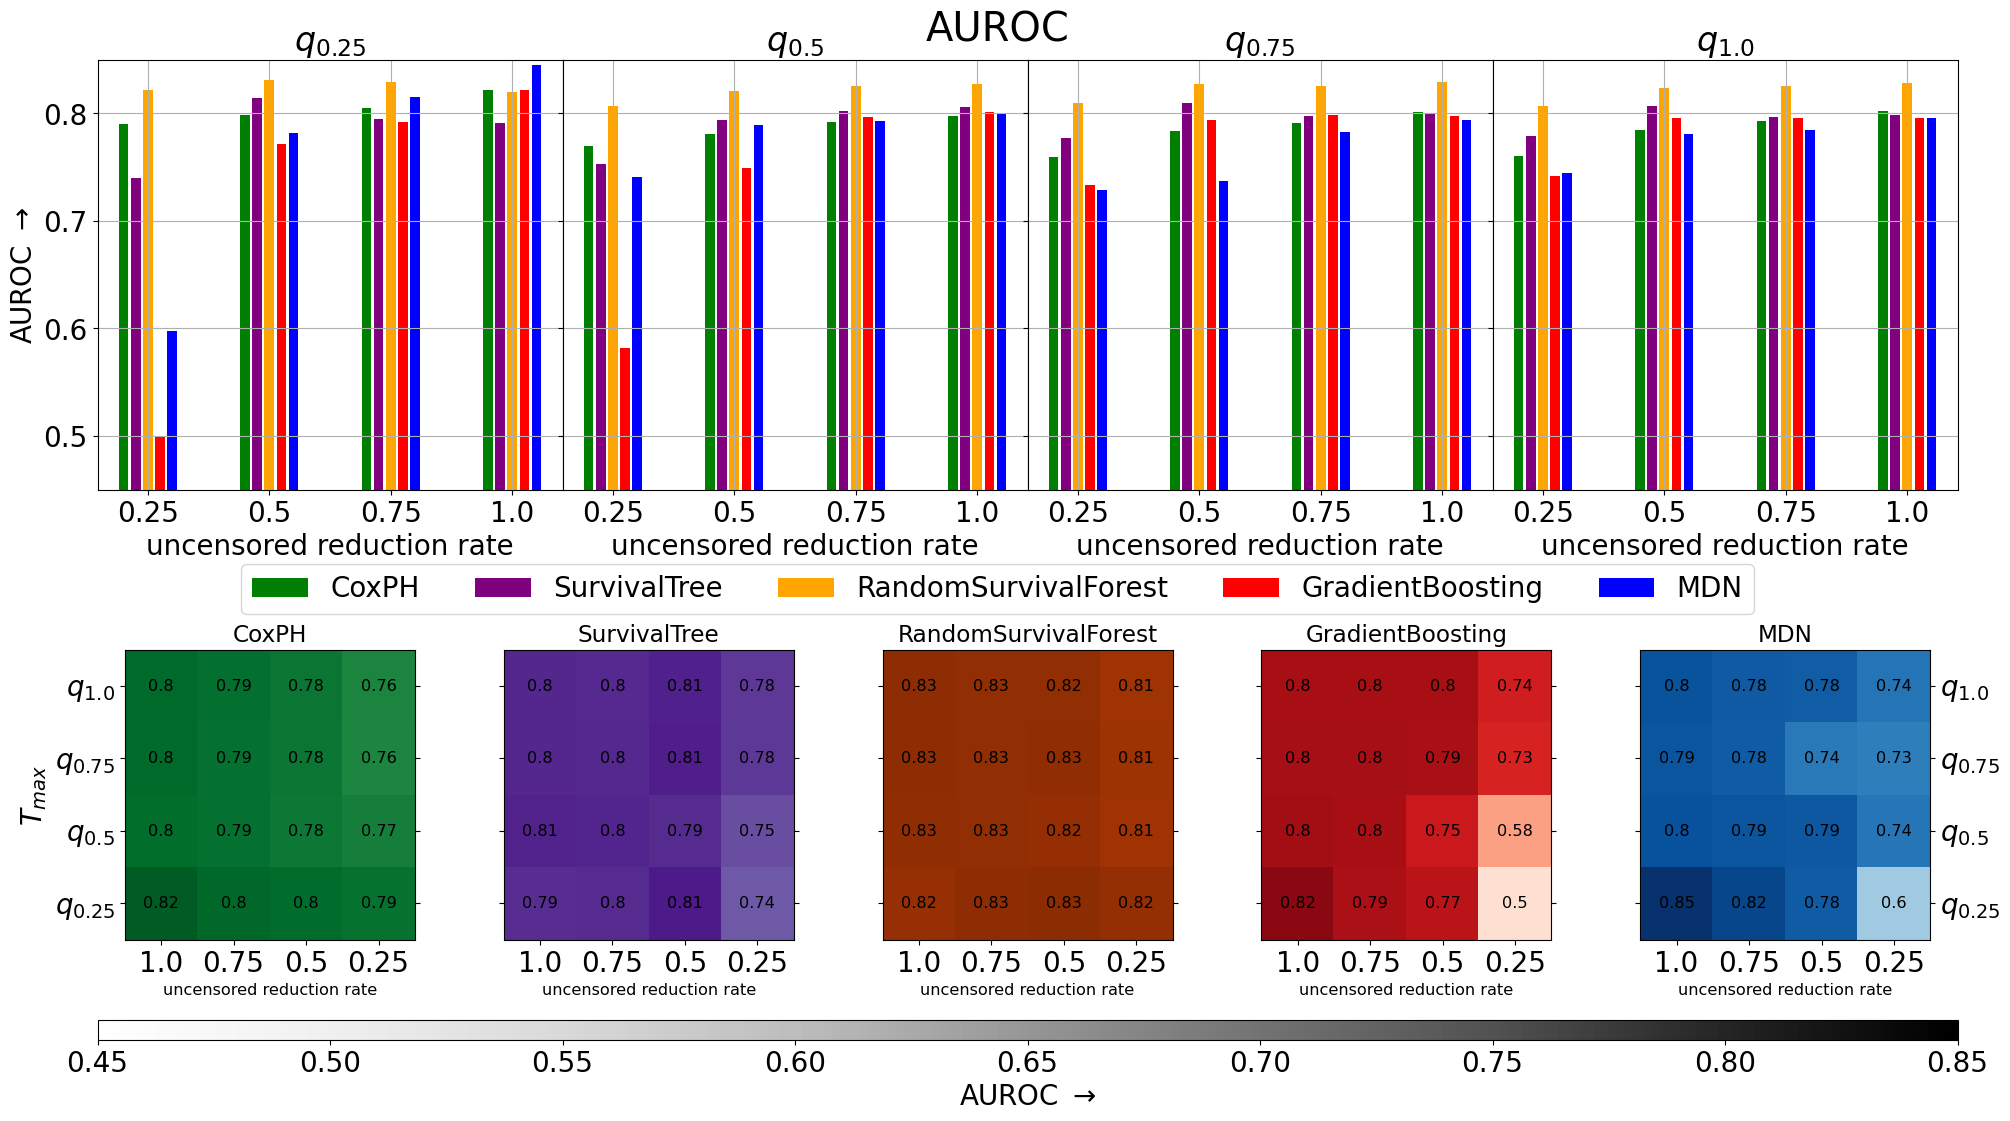

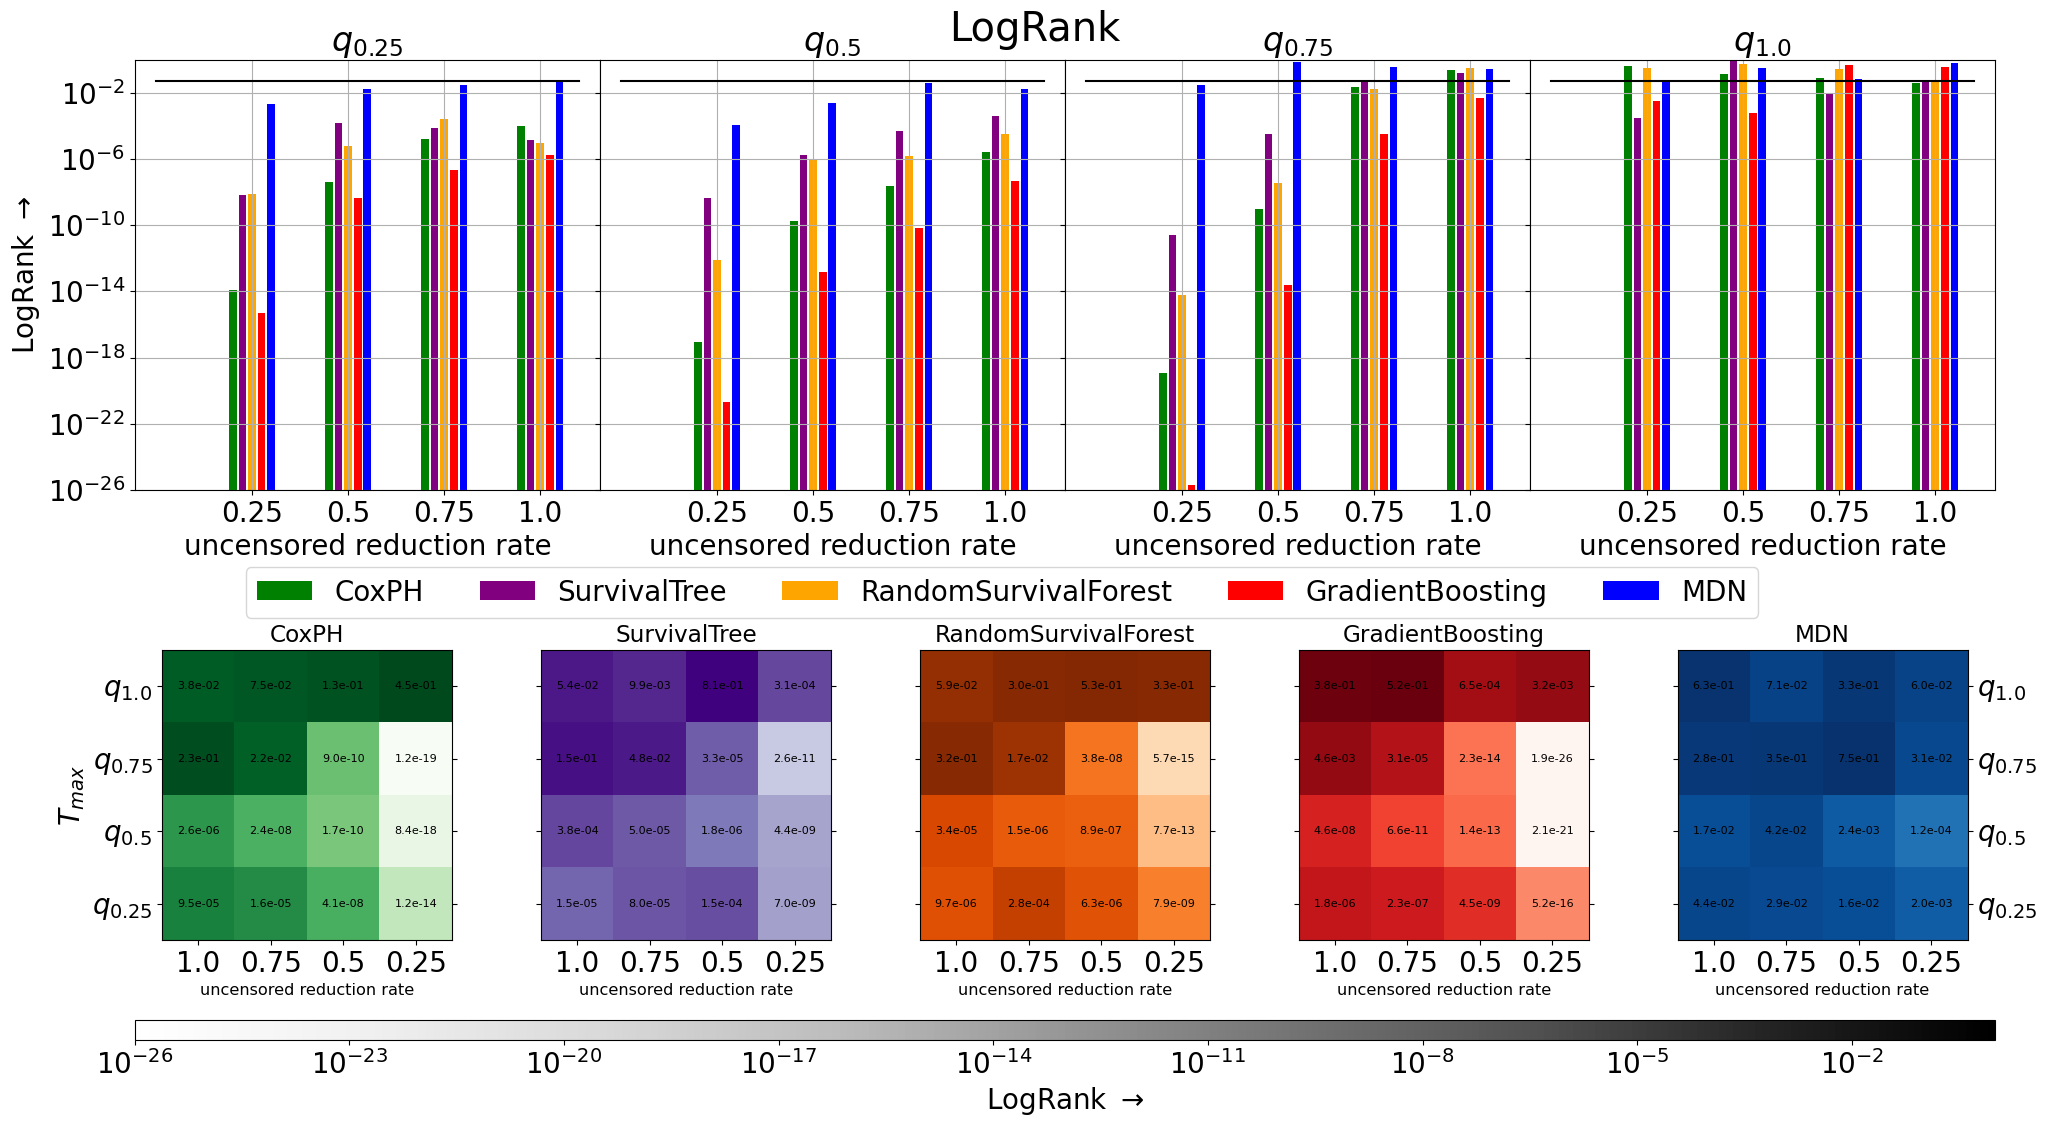

In [31]:
typ = "Hold-out"
scores = ["UnoC $\\rightarrow$","$\\leftarrow$ iBrier","AUROC $\\rightarrow$","LogRank $\\rightarrow$"]
score_names = ["c-index","iBrier","AUROC","LogRank"]
ylims = [[0.55,0.8],[0.0,0.6],[0.45,0.85],[1e-26,1]]

for scr,scr_nm,ylim in zip(scores,score_names,ylims):
    #print(scr)
    fig = plt.figure(figsize=(20,10))

    # GridSpec for the barplots
    gs1 = GridSpec(1, 4, figure = fig, bottom=0.55, top=0.98, left=0.05, right=0.98, wspace = 0.0)
    bar_axs = []
    bar_locs = [0,1,2,3]
    for loc in bar_locs:
        bar_axs.append(fig.add_subplot(gs1[loc]))

    T_maxs = [0.25,0.5,0.75,1.0]
    for loc,T_max in zip(bar_locs,T_maxs):
        for _,row in sensitivity_analysis_[(sensitivity_analysis_.Type == typ) & (sensitivity_analysis_.Score == scr) & (sensitivity_analysis_.T_max == T_max)].iterrows():
            eb = bar_axs[loc].bar(row["Ts"], height = row["means"],width = 0.02, yerr = row["stds"], color = row.Color, label = row["Model"])

        if scr == "LogRank $\\rightarrow$":
            bar_axs[loc].set_yscale("log")
            bar_axs[loc].plot(np.linspace(0,1.1,100),0.05*np.ones(100),marker = "", color = "black")#, label = "LogRank success > 0.05")

        bar_axs[loc].set_xticks([0.25,0.5,0.75,1.0],["0.25","0.5","0.75","1.0"])
        bar_axs[loc].set_xlabel("uncensored reduction rate")
        if scr == "UnoC $\\rightarrow$":
            bar_axs[loc].set_ylabel("c-index $\\rightarrow$")
        else:
            bar_axs[loc].set_ylabel(scr)
        bar_axs[loc].set_ylim((ylim[0],ylim[1]))
        bar_axs[loc].grid()
        bar_axs[loc].set_title("$q_{" + f"{T_max}" +"}$")
        bar_axs[loc].label_outer()

    # GridSpec for the Heatmaps
    gs2 = GridSpec(1,5, figure = fig, bottom=0.1, top=0.39, left=0.05, right=0.98, wspace = 0.1)
    heat_axs = []
    heat_locs = [0,1,2,3,4]
    for loc in heat_locs:
        heat_axs.append(fig.add_subplot(gs2[loc]))
    # GridSpec for the Colorbar
    gs3 = GridSpec(1,1, figure = fig, bottom=0.00, top=0.02, left=0.05, right=0.98, wspace = 0.1)
    cbar_ax = fig.add_subplot(gs3[0])

    models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
    for loc,model in zip(heat_locs,models):
        for _,row in sensitivity_analysis_heatmap[(sensitivity_analysis_heatmap.Model == model) & (sensitivity_analysis_heatmap.Type == typ) & (sensitivity_analysis_heatmap.Score == scr)].iterrows():
            # Normalization
            if scr == "LogRank $\\rightarrow$":
                norm = LogNorm(vmin = ylim[0], vmax = ylim[1])
            else:
                norm = Normalize(vmin = ylim[0], vmax = ylim[1])

            # Heatmap
            im = heat_axs[loc].imshow(np.array(row.means).reshape(4,4), norm = norm, cmap = f"{row.Color}s")

            # Colorbar
            if loc == heat_locs[-1]:
                cbar = fig.colorbar(ScalarMappable(cmap = "Greys", norm = norm), cax = cbar_ax, orientation='horizontal')
                # Colorbar labels
                if scr == "UnoC $\\rightarrow$":
                    cbar.set_label("c-index $\\rightarrow$")
                else:
                    cbar.set_label(scr)

            # Ticks & Tick labels
            heat_axs[loc].set_xticks(np.arange(np.array(row.means).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            heat_axs[loc].set_xlabel("uncensored reduction rate", fontsize = "xx-small")
            heat_axs[loc].set_yticks(np.arange(np.array(row.means).reshape(4,4).shape[0]), labels=["$q_{1.0}$","$q_{0.75}$","$q_{0.5}$","$q_{0.25}$"])
            heat_axs[loc].yaxis.set_ticks_position('both')
            heat_axs[loc].tick_params(labelbottom=True, labeltop=False, labelleft = True, labelright = True)
            heat_axs[loc].set_ylabel("$T_{max}$")
            heat_axs[loc].label_outer()

            heat_axs[loc].set_title(model, fontsize = "small")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    clr = "black"
                    #clr = ScalarMappable(cmap = f"Greys_r", norm = norm).to_rgba(np.array(row.means).reshape(4,4)[i,j])
                    if scr == "LogRank $\\rightarrow$":
                        #if np.array(row.means).reshape(4,4)[i,j] < 0.05:
                        #    clr = "red"
                        mean = "{:.1e}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.1e}".format(np.array(row.stds).reshape(4,4)[i,j])
                        text_size = 8
                    else:
                        mean = "{:.2}".format(np.array(row.means).reshape(4,4)[i,j])
                        std = "{:.2}".format(float(np.array(row.stds).reshape(4,4)[i,j]))
                        text_size = "xx-small"
                    if typ == "5Fold":
                        scr_str = f"${mean}$\n$\pm {std}$"
                    else:
                        scr_str = f"{mean}"
                    text = heat_axs[loc].text(j, i, scr_str,ha="center", va="center", size = text_size, color = clr)

    handles, labels = bar_axs[bar_locs[-1]].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.12,0.452),ncol = 5)
    fig.suptitle(scr_nm, y = 1.03, fontsize = "x-large")
    plt.show()

### Correlation

In [100]:
from scipy.stats import spearmanr

In [101]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
colors = ["green","purple","orange","red","blue"]
markers = ["o","v","s","D","*"]
opts = [True]
typs = ["5Fold","Hold-out"]
trials = list(product(models,opts,typs))

sensitivity_analysis_corr  = {"Model":[],
                              "Type":[],
                              "corrs":[],
                              "pvals":[]}

for trial in trials:
    sensitivity_analysis_corr["Model"].append(trial[0])
    sensitivity_analysis_corr["Type"].append(trial[2])

    # Baseline
    baseline = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1) & (results_table["Uncensored_Reduction"][i] == 1):
            if trial[2] == "5Fold":
                baseline.append(results_table[trial[2]]["UnoC"]["mean"][i])
                baseline.append(results_table[trial[2]]["iBrier"]["mean"][i])
                baseline.append(results_table[trial[2]]["AUROC"]["mean"][i])
                baseline.append(results_table[trial[2]]["LogRank"]["mean"][i])
            else:
                baseline.append(results_table[trial[2]]["UnoC"][i])
                baseline.append(results_table[trial[2]]["iBrier"][i])
                baseline.append(results_table[trial[2]]["AUROC"][i])
                baseline.append(results_table[trial[2]]["LogRank"][i])
    baseline = np.array(baseline)

    ts = []
    corrs = []
    pvals = []
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]):
            if trial[2] == "5Fold":
                current = []
                current.append(results_table[trial[2]]["UnoC"]["mean"][i])
                current.append(results_table[trial[2]]["iBrier"]["mean"][i])
                current.append(results_table[trial[2]]["AUROC"]["mean"][i])
                current.append(results_table[trial[2]]["LogRank"]["mean"][i])
                current = np.array(current)
            else:
                current = []
                current.append(results_table[trial[2]]["UnoC"][i])
                current.append(results_table[trial[2]]["iBrier"][i])
                current.append(results_table[trial[2]]["AUROC"][i])
                current.append(results_table[trial[2]]["LogRank"][i])
                current = np.array(current)
            spearman_result = spearmanr(current,baseline)
            corrs.append(spearman_result.correlation)
            pvals.append(spearman_result.pvalue)
    sensitivity_analysis_corr["corrs"].append(corrs)
    sensitivity_analysis_corr["pvals"].append(pvals)

sensitivity_analysis_corr = pd.DataFrame.from_dict(sensitivity_analysis_corr)

CoxPH


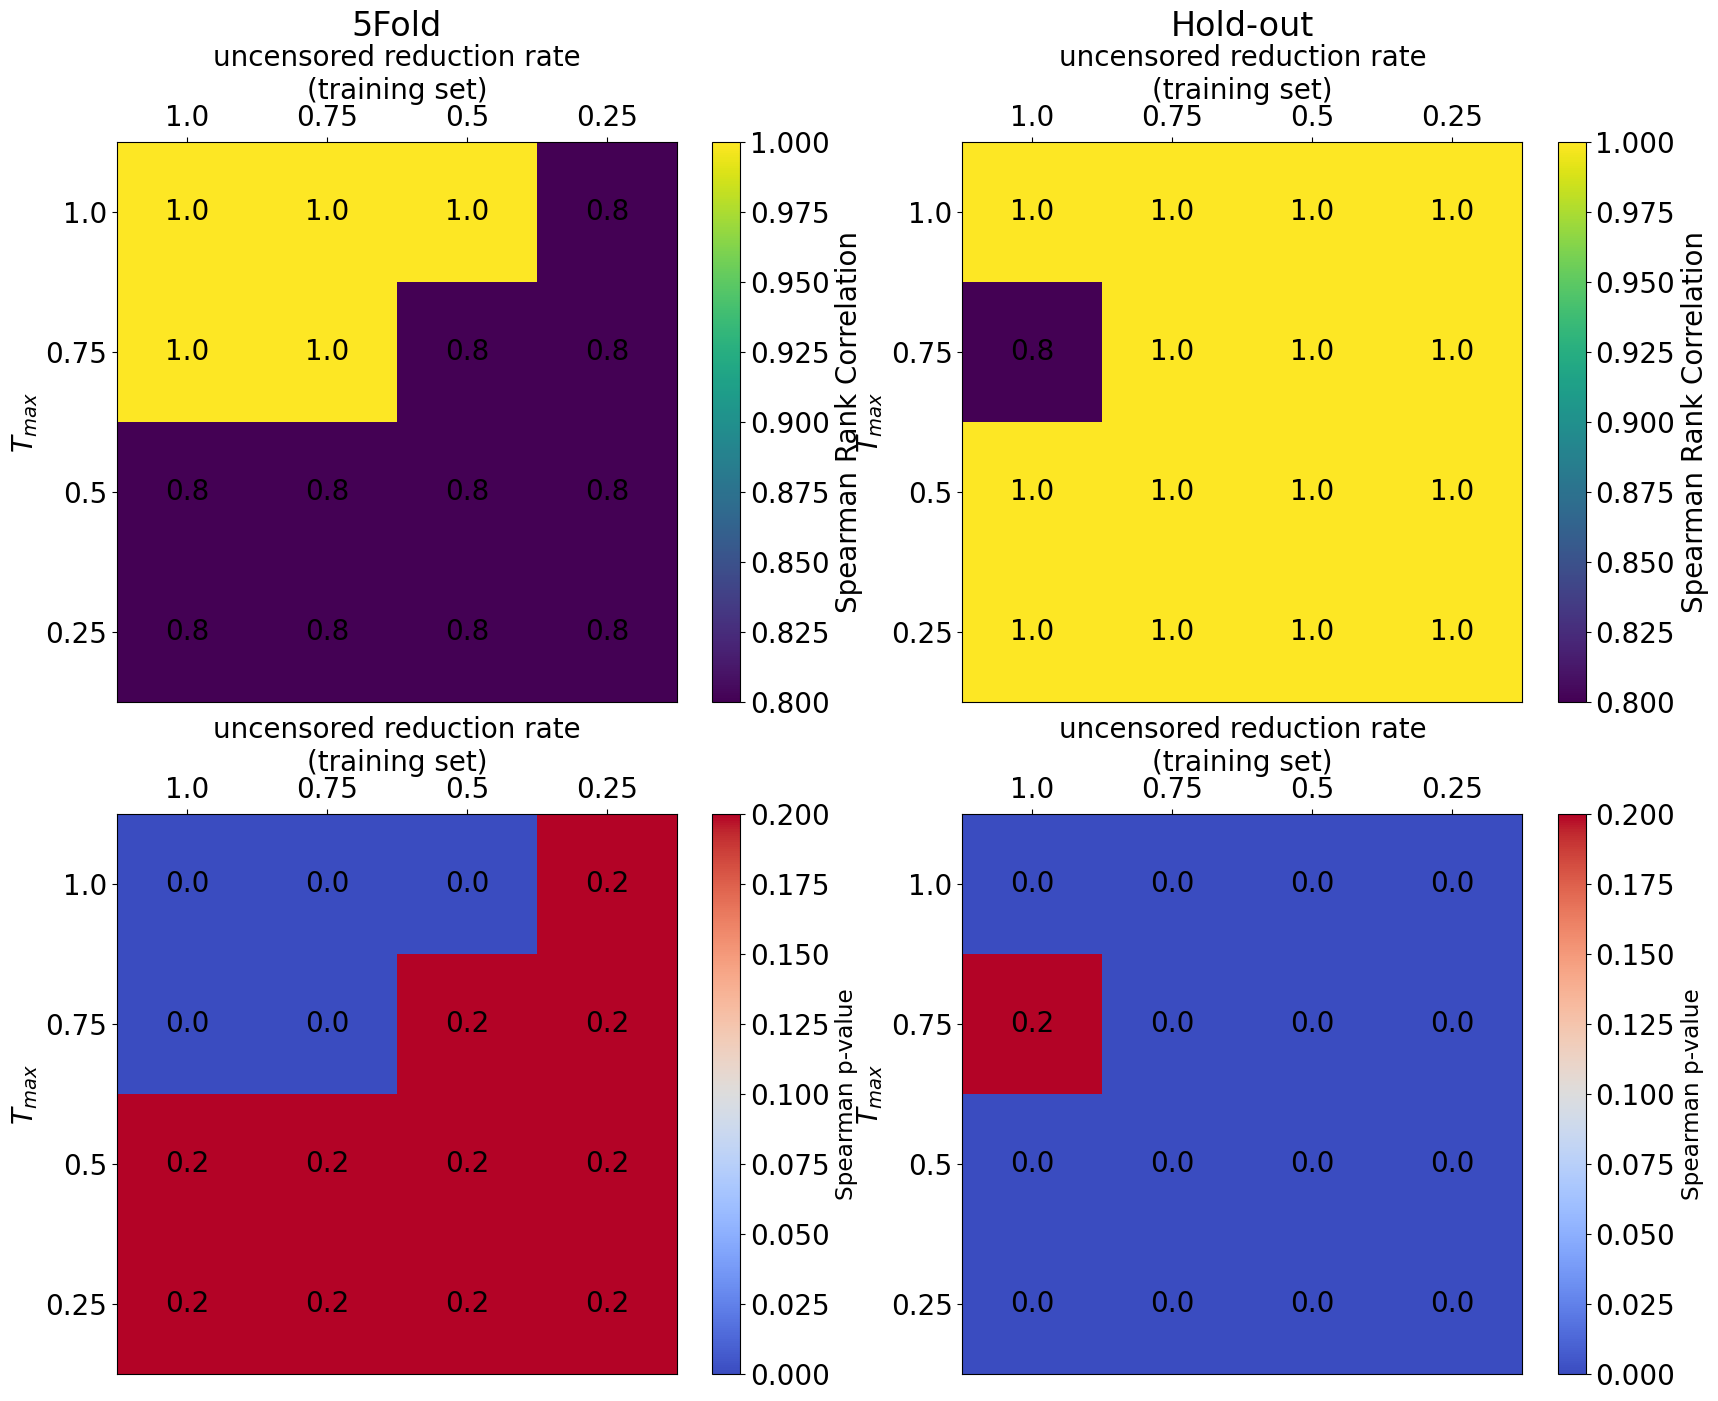

SurvivalTree


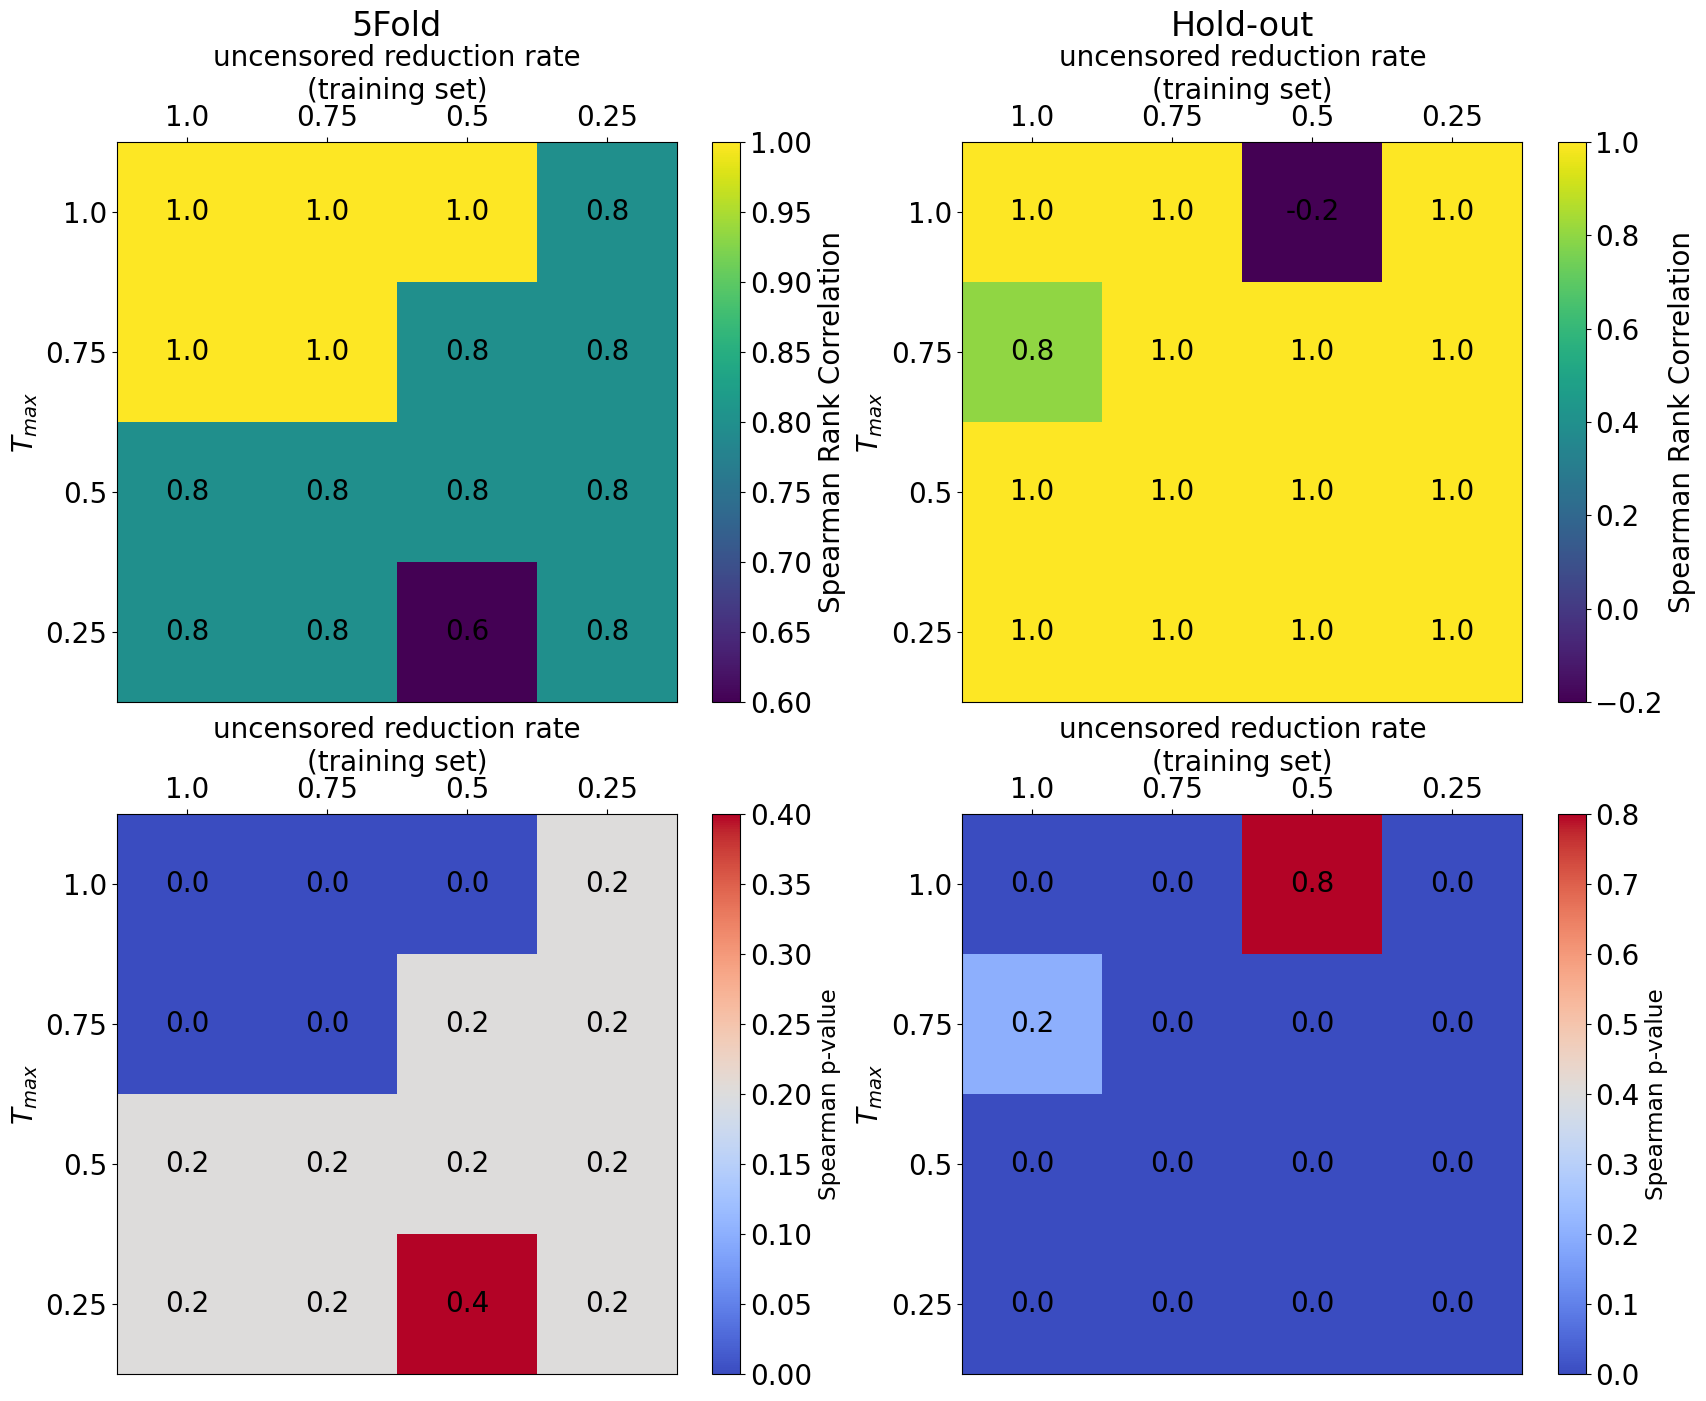

RandomSurvivalForest


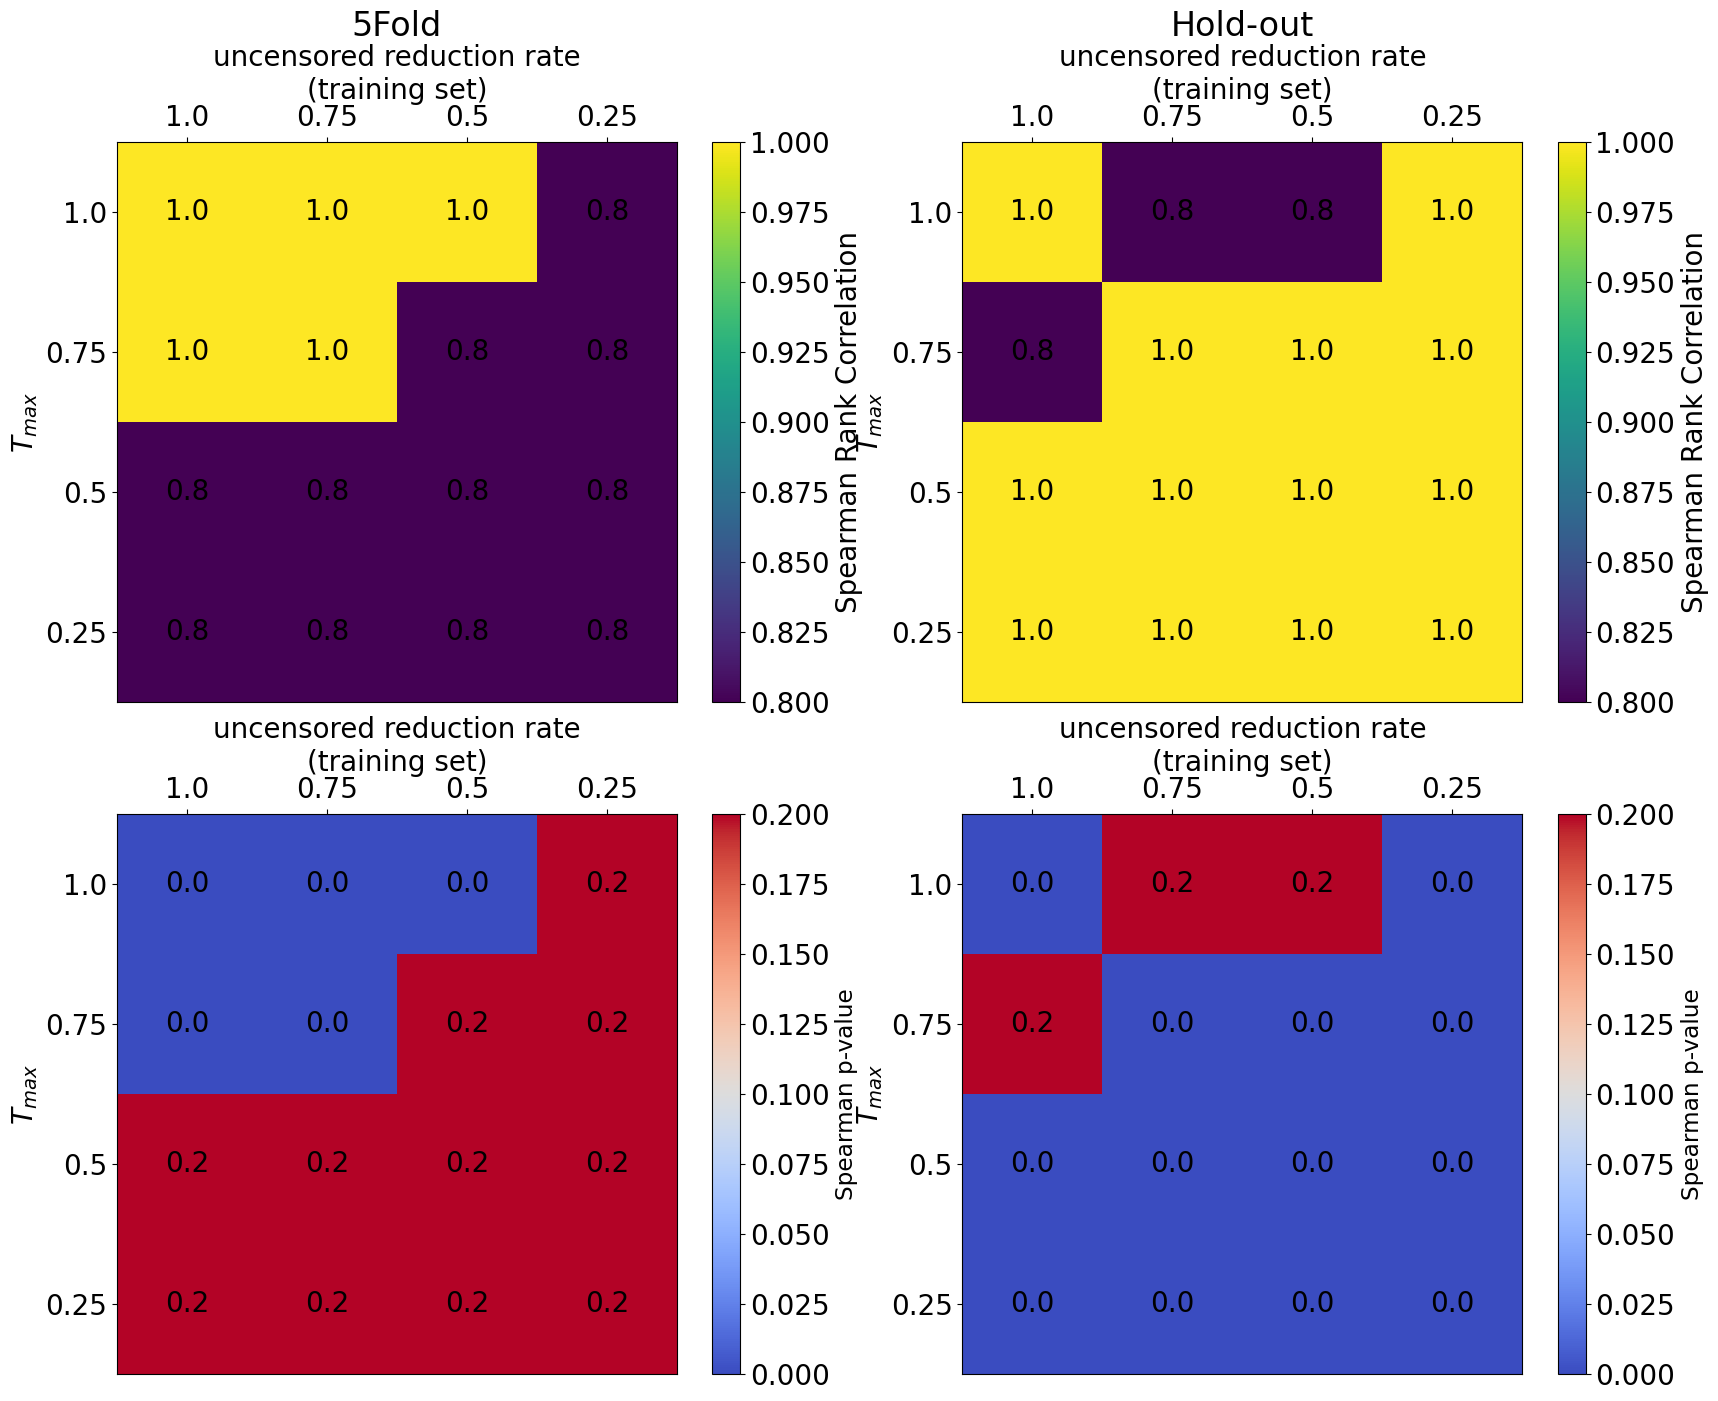

GradientBoosting


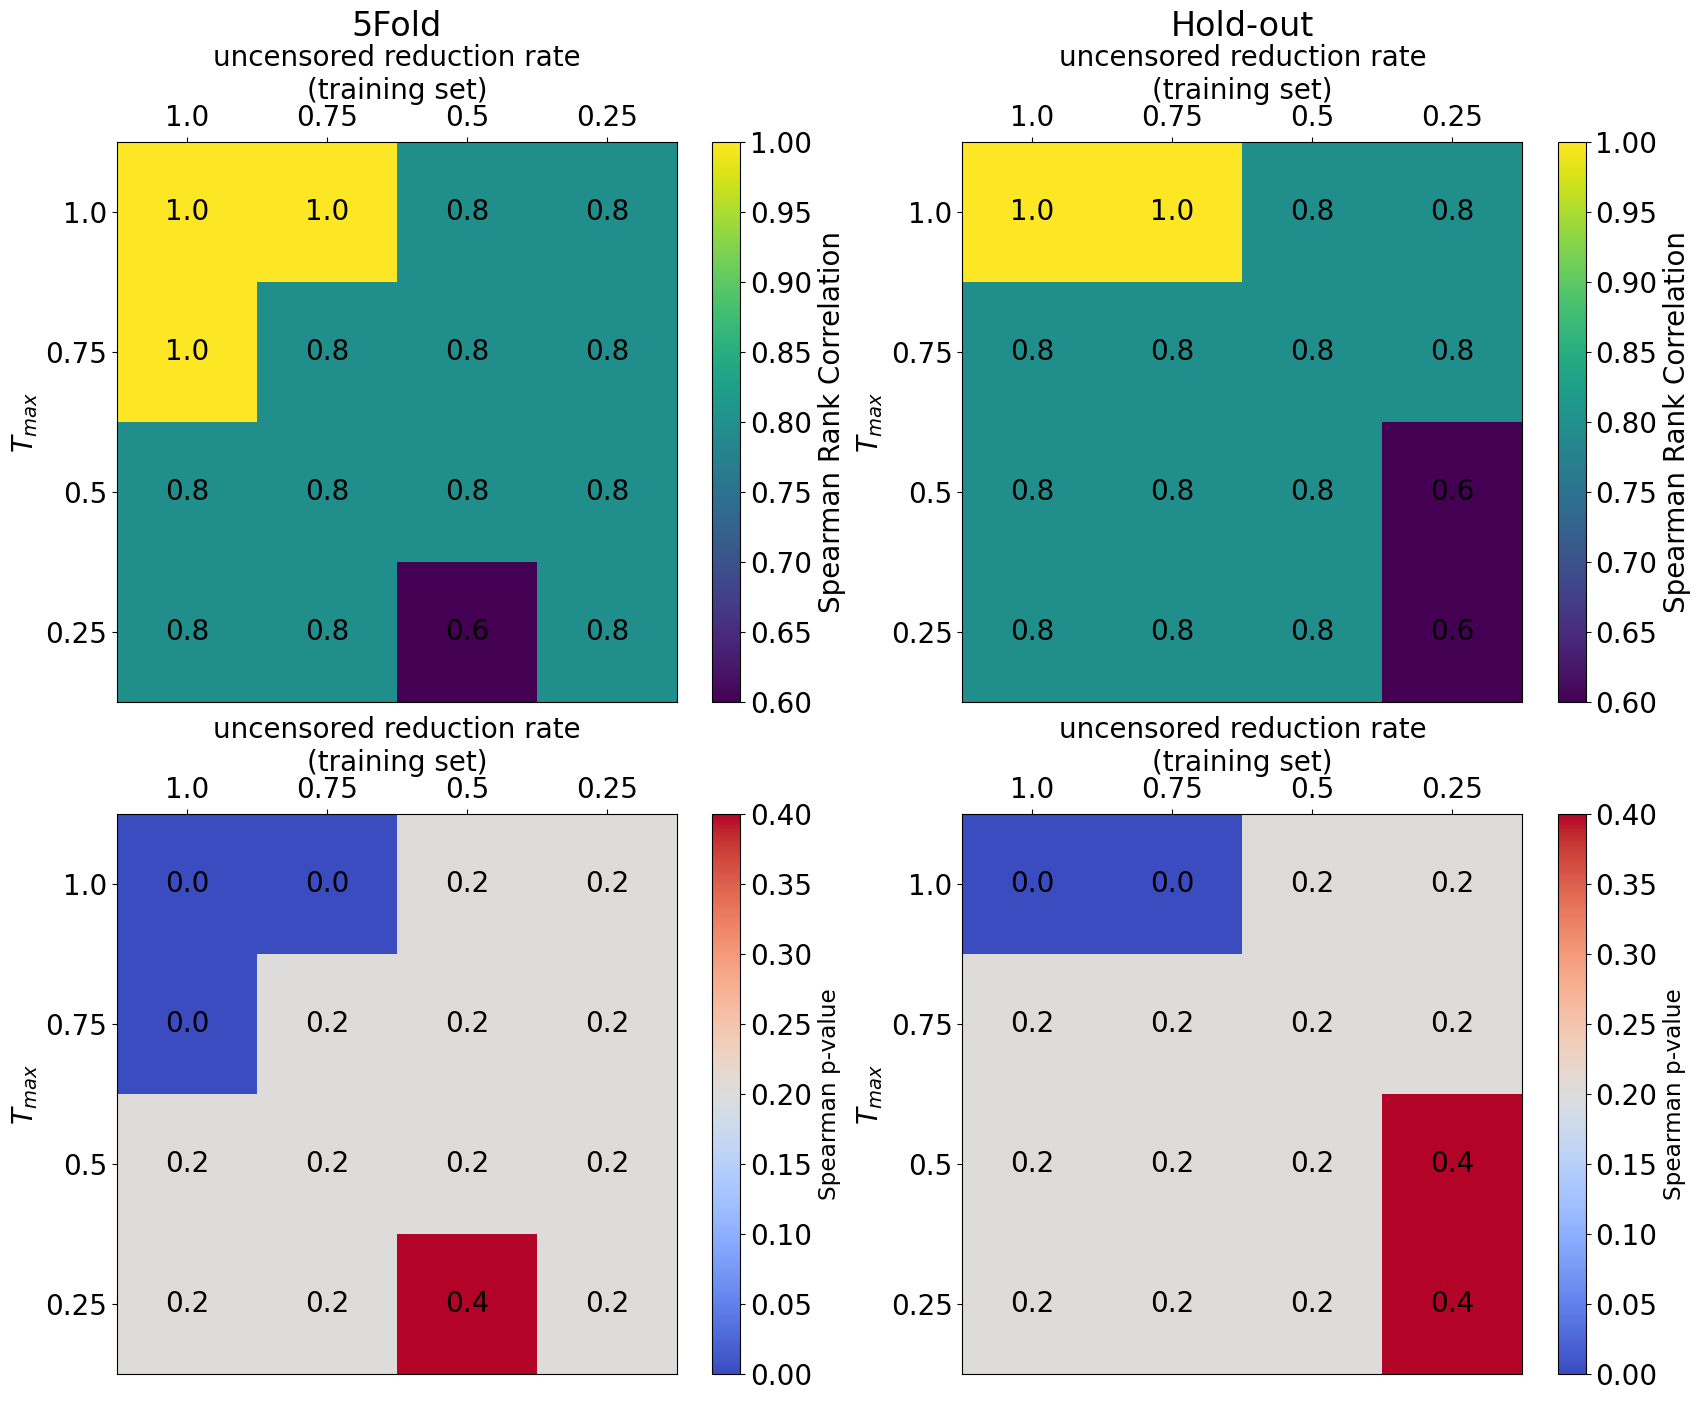

MDN


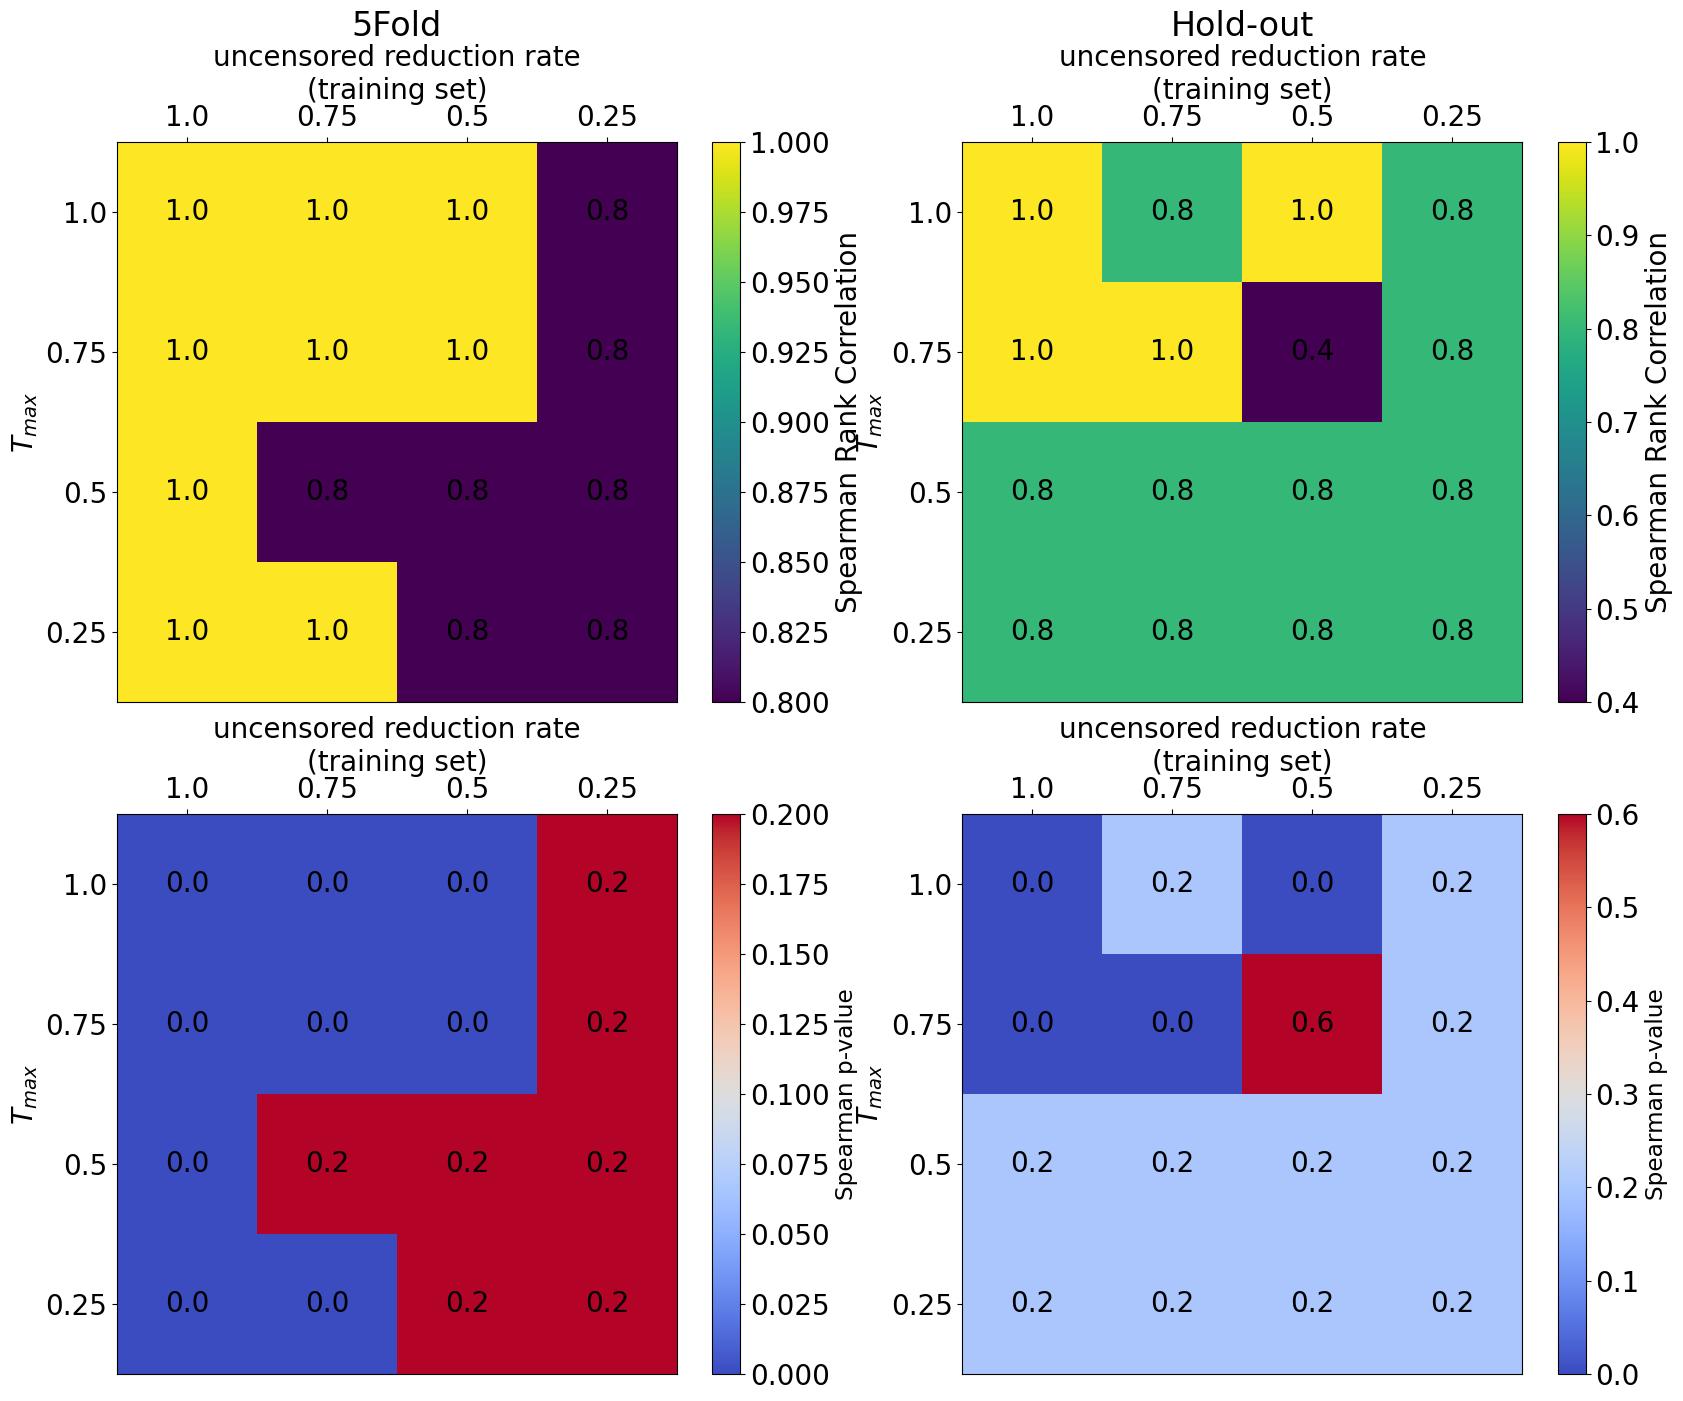

In [102]:
Models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
for model in Models:
    print(model)
    fig, axs = plt.subplots(2,2,figsize=(20,16))
    typs = ["5Fold","Hold-out"]
    locs = [[0,0],[0,1]]
    #ylims = [[0.28,0.85],[-0.7,2.1],[0.5,1.0],[1e-3,1]]

    for typ,loc in zip(typs,locs):
        for _,row in sensitivity_analysis_corr[(sensitivity_analysis_corr.Model == model) & (sensitivity_analysis_corr.Type == typ)].iterrows():
            # Correlation
            # Normalization
            norm = Normalize(vmin = np.array(row.corrs).min(), vmax = np.array(row.corrs).max())
            # Heatmap & Colorbar
            im = axs[loc[0]][loc[1]].imshow(np.array(row.corrs).reshape(4,4), norm = norm)
            cbar = axs[loc[0]][loc[1]].figure.colorbar(im)

            # Ticks & Tick labels
            axs[loc[0]][loc[1]].set_xticks(np.arange(np.array(row.corrs).reshape(4,4).shape[1]), labels=red_rates)
            axs[loc[0]][loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
            axs[loc[0]][loc[1]].xaxis.set_ticks_position('top')
            #axs[loc[0]][loc[1]].tick_params(labelbottom=True, labeltop=True)
            axs[loc[0]][loc[1]].xaxis.set_label_position('top')
            axs[loc[0]][loc[1]].set_yticks(np.arange(np.array(row.corrs).reshape(4,4).shape[0]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]][loc[1]].set_ylabel("$T_{max}$")

            # Colorbar labels
            cbar.set_label("Spearman Rank Correlation")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    corr = "{:.5}".format(np.array(row.corrs).reshape(4,4)[i,j])
                    scr_str = f"{corr}"
                    text = axs[loc[0]][loc[1]].text(j, i, scr_str,ha="center", va="center", size = "medium")

            # Title
            axs[loc[0]][loc[1]].set_title(typ)

            # p-value
            # Normalization
            norm = Normalize(vmin = np.array(row.pvals).min(), vmax = np.array(row.pvals).max())
            # Heatmap & Colorbar
            im = axs[loc[0]+1][loc[1]].imshow(np.array(row.pvals).reshape(4,4), norm = norm,  cmap = "coolwarm")
            cbar = axs[loc[0]+1][loc[1]].figure.colorbar(im, cmap = "coolwarm")

            # Ticks & Tick labels
            axs[loc[0]+1][loc[1]].set_xticks(np.arange(np.array(row.pvals).reshape(4,4).shape[1]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]+1][loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
            axs[loc[0]+1][loc[1]].xaxis.set_ticks_position('top')
            axs[loc[0]+1][loc[1]].xaxis.set_label_position('top')
            axs[loc[0]+1][loc[1]].set_yticks(np.arange(np.array(row.pvals).reshape(4,4).shape[0]), labels=[1.0,0.75,0.5,0.25])
            axs[loc[0]+1][loc[1]].set_ylabel("$T_{max}$")

            # Colorbar labels
            cbar.set_label("Spearman p-value", fontsize = "small")

            # Scores as text
            for i in range(len(red_rates)):
                for j in range(len(T_maxs)):
                    pval = "{:.5}".format(np.array(row.pvals).reshape(4,4)[i,j])
                    scr_str = f"{pval}"
                    text = axs[loc[0]+1][loc[1]].text(j, i, scr_str,ha="center", va="center", size = "medium")

    #fig.tight_layout()
    plt.show()

#### Visualizing the change in dataset quality

In [103]:
from utils import reduce_T_max,reduce_uncensored
from lifelines.fitters.coxph_fitter import CoxPHFitter

y_baseline = y_train.copy()

five_fold_mean = np.zeros((len(T_maxs),len(red_rates))).flatten()
five_fold_std = np.zeros((len(T_maxs),len(red_rates))).flatten()
hold_out_res = np.zeros((len(T_maxs),len(red_rates))).flatten()

i = 0
for T_max,red_rate in sensitivity_grid:
    y_red = np.copy(y_baseline)
    y_red = reduce_T_max(y_red,T_max)

    # 5Fold
    kf = KFold(n_splits=5,random_state=42,shuffle=True)
    p_vals = []
    for train_index, test_index in kf.split(y_red):
        y_trn, y_tst = y_red[train_index], y_red[test_index]
        y_trn_baseline, y_tst_baseline = y_baseline[train_index], y_baseline[test_index]
        y_trn = reduce_uncensored(y_trn, red_rate)

        cox_test_df = pd.DataFrame(np.append(np.vstack([y_trn,y_trn_baseline]),np.hstack([np.zeros(len(y_trn)).T,np.ones(len(y_trn_baseline))]).reshape(-1,1),axis=1))

        cph = CoxPHFitter()
        cph.fit(df = cox_test_df,
                duration_col = 0,
                event_col = 1)
        pval = cph.log_likelihood_ratio_test().p_value
        if pval == 0.0:
            pval = 1e-300 #Replacing 0 with a very small float, so we can plot it on a logarithmic scale
        p_vals.append(pval)

    # Hold-out
    y_red = reduce_uncensored(y_red, red_rate)

    cox_test_df = pd.DataFrame(np.append(np.vstack([y_red,y_baseline]),np.hstack([np.zeros(len(y_red)).T,np.ones(len(y_baseline))]).reshape(-1,1),axis=1))

    cph = CoxPHFitter()
    cph.fit(df = cox_test_df,
            duration_col = 0,
            event_col = 1)

    p_val = cph.log_likelihood_ratio_test().p_value
    if p_val == 0.0:
        p_val = 1e-300 #Replacing 0 with a very small float, so we can plot it on a logarithmic scale

    # Adding results to the matrices
    hold_out_res[i] = p_val
    five_fold_mean[i] = np.mean(np.array(p_vals))
    five_fold_std[i] = 1.96*np.std(np.array(p_vals))/np.sqrt(5)

    i += 1

hold_out_res = hold_out_res.reshape((4,4))
five_fold_mean = five_fold_mean.reshape((4,4))
five_fold_std = five_fold_std.reshape((4,4))

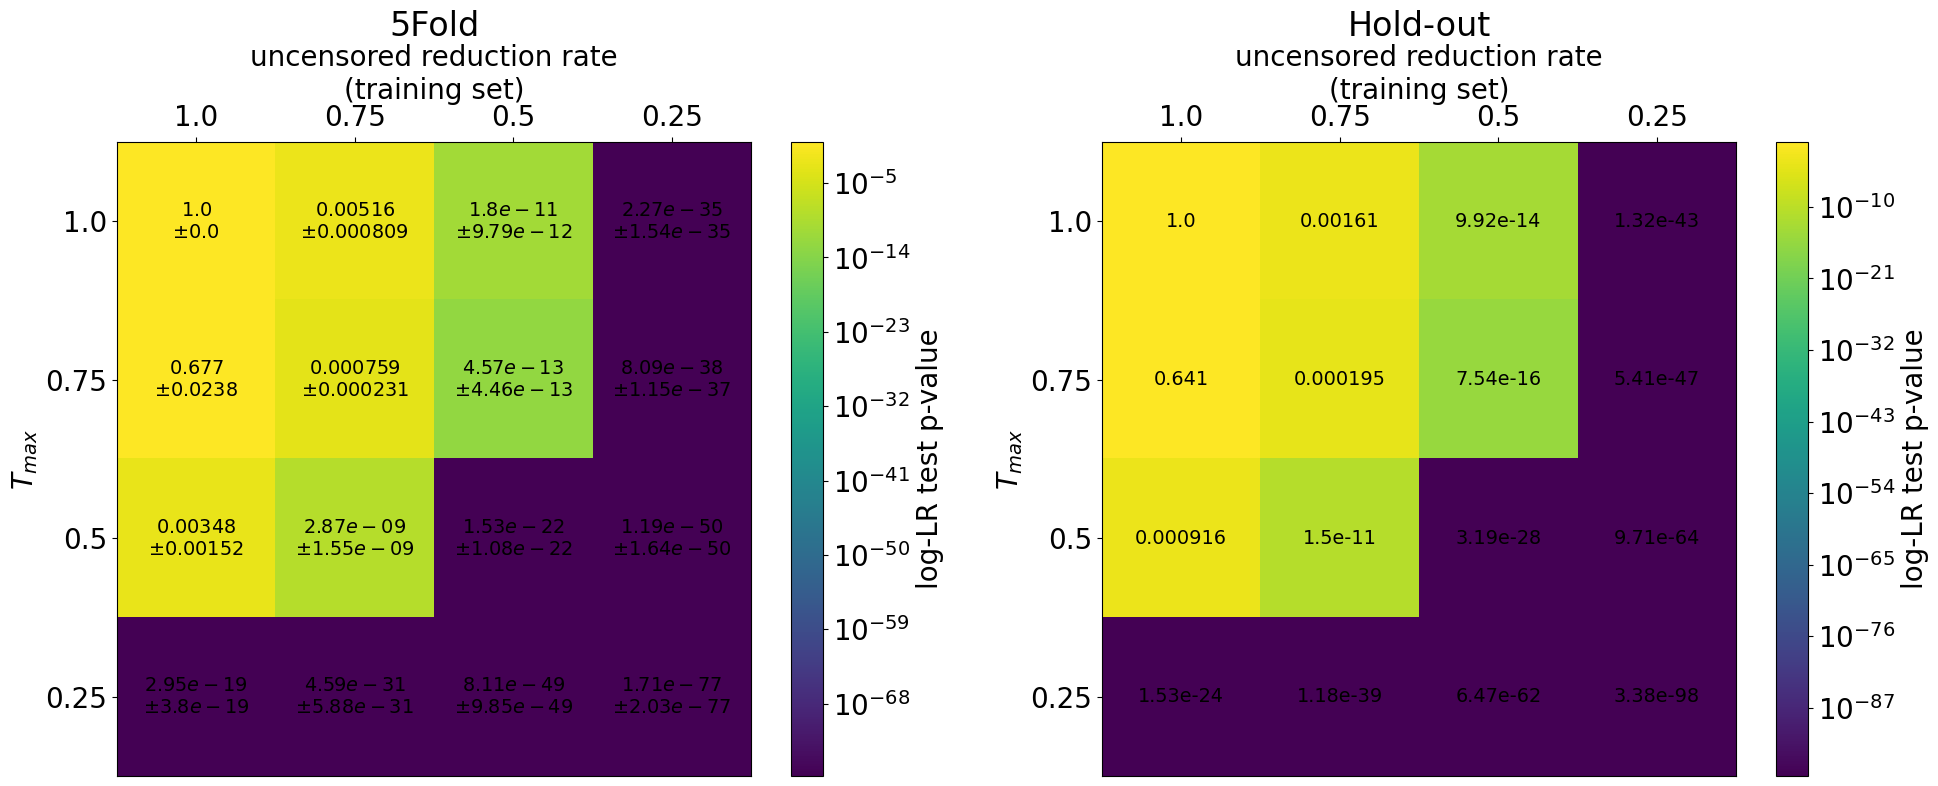

In [108]:
fig, axs = plt.subplots(1,2,figsize=(20,8))
typs = ["5Fold","Hold-out"]
locs = [[0,0],[0,1]]
datas = [five_fold_mean,hold_out_res]

for typ,loc,data in zip(typs,locs,datas):
    # Normalization
    norm = LogNorm(vmin = data.min(), vmax = data.max())

    # Heatmap & Colorbar
    im = axs[loc[1]].imshow(data, norm = norm)
    cbar = axs[loc[1]].figure.colorbar(im)

    # Ticks & Tick labels
    axs[loc[1]].set_xticks(np.arange(data.shape[1]), labels=[1.0,0.75,0.5,0.25])
    axs[loc[1]].set_xlabel("uncensored reduction rate\n(training set)")
    axs[loc[1]].xaxis.set_ticks_position('top')
    #axs[loc[0]][loc[1]].tick_params(labelbottom=True, labeltop=True)
    axs[loc[1]].xaxis.set_label_position('top')
    axs[loc[1]].set_yticks(np.arange(data.shape[0]), labels=[1.0,0.75,0.5,0.25])
    axs[loc[1]].set_ylabel("$T_{max}$")

    # Colorbar labels
    cbar.set_label("log-LR test p-value")

    # Scores as text
    for i in range(len(red_rates)):
        for j in range(len(T_maxs)):
            mean = "{:.3}".format(data[i,j])
            std = "{:.3}".format(five_fold_std[i,j])
            if typ == "5Fold":
                scr_str = f"${mean}$\n$\pm {std}$"
            else:
                scr_str = f"{mean}"
            text = axs[loc[1]].text(j, i, scr_str,ha="center", va="center", size = "x-small")

    # Title
    axs[loc[1]].set_title(typ)

fig.tight_layout()
plt.show()

In [105]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

for _,row in sensitivity_analysis_corr.iterrows():
    print(f"{row.Model}, {row.Type}")
    y_pred = MinMaxScaler().fit_transform(np.array(row.corrs).reshape(-1, 1))
    if row.Type == "5Fold":
        y_true = five_fold_mean.flatten()
        y_true_low = five_fold_mean.flatten() - five_fold_std.flatten()
        y_true_high = five_fold_mean.flatten() + five_fold_std.flatten()
        score = mean_squared_error(y_true, y_pred, squared=False)
        score_low = mean_squared_error(y_true_low, y_pred, squared=False)
        score_high = mean_squared_error(y_true_high, y_pred, squared=False)
        print(f"{score} +/- {score_low-score_high}")
    else:
        y_true = hold_out_res.flatten()
        score = mean_squared_error(y_true, y_pred, squared=False)
        print(score)

CoxPH, 5Fold
0.43965396275607166 +/- 0.0024846730900232594
CoxPH, Hold-out
0.9488541773980852
SurvivalTree, 5Fold
0.5910397184590233 +/- 0.0020093424505140955
SurvivalTree, Hold-out
0.9024836497968146
RandomSurvivalForest, 5Fold
0.43965396275607166 +/- 0.0024846730900232594
RandomSurvivalForest, Hold-out
0.880639310112452
GradientBoosting, 5Fold
0.5055940984688142 +/- 0.0023203177282684617
GradientBoosting, Hold-out
0.4851221689368111
MDN, 5Fold
0.6654774909669074 +/- 0.0019276036876045843
MDN, Hold-out
0.6621062969308293


## Degradation

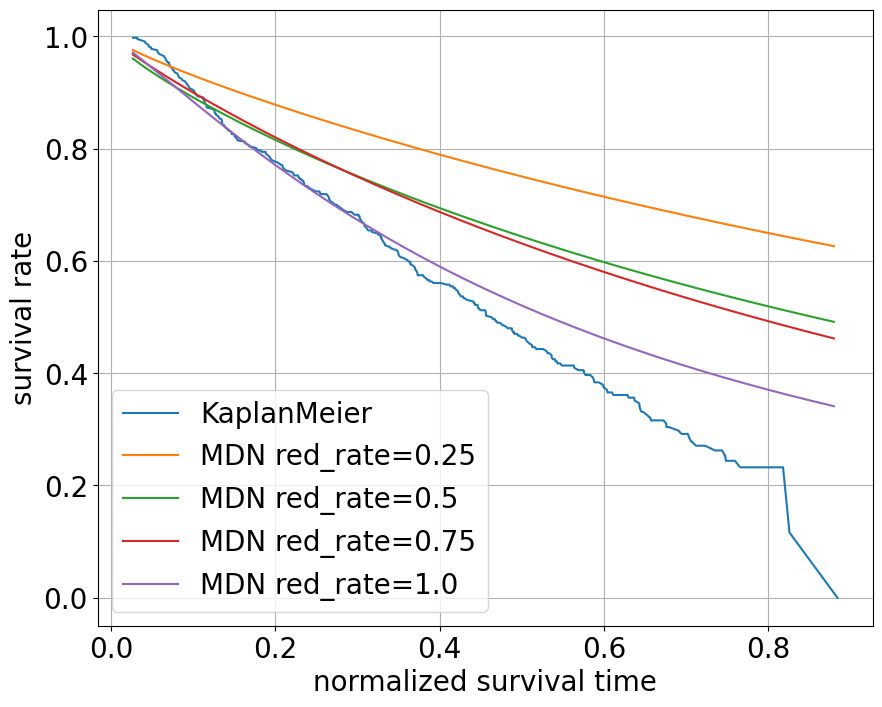

In [32]:
models = ["MDN"]
opts = [True]
red_rates = [0.25,0.5,0.75,1.0]
trials = list(product(models,opts,red_rates))

compare_survival  = {"Model":[],
                     "Timeline":[],
                     "Survival_Function":[]}

for trial in trials:
    for i in range(len(results_table["Model"])):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == 1.0) & (results_table["Uncensored_Reduction"][i] == trial[2]):
            compare_survival["Model"].append(f"{trial[0]} red_rate={trial[2]}")
            compare_survival["Timeline"].append(results_table["Timeline"][i])
            compare_survival["Survival_Function"].append(results_table["Overall_Survival_Function"][i])
            

plt.figure(figsize=(10,8))
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# Filter the test set for t > max(t_train), as these can cause problems for the scores (...)
t_max = min([max(y_train[:,0]),max(y_test[:,0])])
t_min = max([min(y_train[:,0]),min(y_test[:,0])])
mask = (t_min <= y_test[:,0]) & (y_test[:,0] <= t_max)
X_test = X_test[mask]
y_test = y_test[mask]
km_timeline, km_prob_survival = kaplan_meier_estimator(y_test[:,1].astype(bool),y_test[:,0])
plt.plot(km_timeline,km_prob_survival, label = "KaplanMeier")

for i in range(len(compare_survival["Model"])):
    plt.plot(compare_survival["Timeline"][i], compare_survival["Survival_Function"][i], label = compare_survival["Model"][i])
plt.legend()
plt.grid()
#plt.title(f"Worsening of survival rate estimate for the population of the {NAME_PLOT} hold-out set\nwith the reduction of uncensored patients in the training set")
plt.xlabel("normalized survival time")
plt.ylabel("survival rate")
#plt.xscale("log")
#plt.yscale("log")
plt.show()

## All results

In [35]:
models = ["CoxPH","SurvivalTree","RandomSurvivalForest","GradientBoosting","MDN"]
opts = [True,False]
T_maxs = [1.0,0.75,0.5,0.25]
red_rates = [1.0,0.75,0.5,0.25]
trials = list(product(models,opts,T_maxs,red_rates))

master_results  = {"Model":[],
                   "T_max":[],
                   "Uncensored Reduction":[],
                   "5Fold - c-index":[],
                   "5Fold - iBrier":[],
                   "5Fold - AUROC":[],
                   "5Fold - LogRank":[],
                   "Hold-out - c-index":[],
                   "Hold-out - iBrier":[],
                   "Hold-out - AUROC":[],
                   "Hold-out - LogRank":[]}

for trial in trials:
    for i in range(len(results_table["Model"])-1):
        if (results_table["Model"][i] == trial[0]) & (results_table["Optimized_LogRank"][i] == trial[1]) & (results_table["T_max"][i] == trial[2]) & (results_table["Uncensored_Reduction"][i] == trial[3]):
            master_results["Model"].append(f"{trial[0]} " + ["$_{LogRank}$" if trial[1] == True else ""][0])
            master_results["T_max"].append(results_table["T_max"][i])
            master_results["Uncensored Reduction"].append(results_table["Uncensored_Reduction"][i])
            master_results["5Fold - c-index"].append( str(round(results_table["5Fold"]["UnoC"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["UnoC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - iBrier"].append( str(round(results_table["5Fold"]["iBrier"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["iBrier"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - AUROC"].append( str(round(results_table["5Fold"]["AUROC"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["AUROC"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["5Fold - LogRank"].append( str(round(results_table["5Fold"]["LogRank"]["mean"][i],4)).ljust(6,"0") +" ± " + str(round(1.96*results_table["5Fold"]["LogRank"]["std"][i]/np.sqrt(5),4)).ljust(6,"0") )
            master_results["Hold-out - c-index"].append( str(round(results_table["Hold-out"]["UnoC"][i],4)).ljust(6,"0") )
            master_results["Hold-out - iBrier"].append( str(round(results_table["Hold-out"]["iBrier"][i],4)).ljust(6,"0") )
            master_results["Hold-out - AUROC"].append( str(round(results_table["Hold-out"]["AUROC"][i],4)).ljust(6,"0") )
            master_results["Hold-out - LogRank"].append( str(round(results_table["Hold-out"]["LogRank"][i],4)).ljust(6,"0") )
            
master_results = pd.DataFrame.from_dict(master_results)

In [36]:
master_results

Model  T_max  Uncensored Reduction  5Fold - c-index  \
0    CoxPH $_{LogRank}$   1.00                  1.00  0.7454 ± 0.0112   
1    CoxPH $_{LogRank}$   1.00                  0.75  0.7047 ± 0.0393   
2    CoxPH $_{LogRank}$   1.00                  0.50  0.6313 ± 0.0783   
3    CoxPH $_{LogRank}$   1.00                  0.25  0.6012 ± 0.1001   
4    CoxPH $_{LogRank}$   0.75                  1.00  0.7463 ± 0.0119   
..                  ...    ...                   ...              ...   
154                MDN    0.50                  0.25  0.7229 ± 0.0258   
155                MDN    0.25                  1.00  0.8160 ± 0.0255   
156                MDN    0.25                  0.75  0.8042 ± 0.0313   
157                MDN    0.25                  0.50  0.7937 ± 0.0194   
158                MDN    0.25                  0.25  0.7685 ± 0.0425   

      5Fold - iBrier    5Fold - AUROC  5Fold - LogRank Hold-out - c-index  \
0    0.1457 ± 0.0078  0.8169 ± 0.0118  0.4690 ± 0.2674             0.7370   
1    0.1879 ± 0.0128  0.8118 ± 0.0118  0.5397 ± 0.2287             0.7221   
2    0.2678 ± 0.0190  0.8036 ± 0.0135  0.3635 ± 0.2812             0.6960   
3    0.4365 ± 0.0171  0.7874 ± 0.0183  0.0361 ± 0.0631             0.6498   
4    0.1489 ± 0.0088  0.8162 ± 0.0123  0.4364 ± 0.1827             0.7356   
..               ...              ...              ...                ...   
154  0.2747 ± 0.0109  0.7817 ± 0.0346  0.2072 ± 0.0919             0.6885   
155  0.1281 ± 0.0140  0.8721 ± 0.0267  0.1946 ± 0.0604             0.7797   
156  0.1347 ± 0.0085  0.8582 ± 0.0313  0.1616 ± 0.0533             0.7540   
157  0.1536 ± 0.0095  0.8427 ± 0.0170  0.1162 ± 0.0413             0.7482   
158  0.1889 ± 0.0097  0.8137 ± 0.0465  0.0900 ± 0.0513             0.7174   

    Hold-out - iBrier Hold-out - AUROC Hold-out - LogRank  
0              0.1429           0.8019             0.0384  
1              0.1888           0.7934             0.0745  
2              0.2831           0.7843             0.1305  
3              0.4667           0.7605             0.4451  
4              0.1469           0.8016             0.2306  
..                ...              ...                ...  
154            0.2905           0.7746             0.0938  
155            0.1210           0.8533             0.0842  
156            0.1482           0.8201             0.0611  
157            0.1598           0.8067             0.0404  
158            0.1952           0.7719             0.0323  

[159 rows x 11 columns]

In [37]:
# CSV version for the Paper
master_results.to_csv(f"Logs/{NAME}_results.csv",index=False)